Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
241                           NaN                Thailand  15.870032   
242                           NaN             Timor-Leste  -8.874217   
243                           NaN                    Togo   8.619500   
244                           NaN     Trinidad and Tobago  10.691800   
245                           NaN                 Tunisia  33.886917   
246                           NaN                  Turkey  38.963700   
247                           NaN           United States  40.000000   
248                           NaN                  Uganda   1.373333   
249                           NaN                 Ukraine  48.379400   
250                           NaN    United Arab Emirates  23.424076   
251                      Anguilla          United Kingdom  18.220600   
252                       Bermuda          United Kingdom  32.307800   
253        British Virgin Islands          United Kingdom  18.420700   
254                Cayman Islands          United Kingdom  19.313300   
255               Channel Islands          United Kingdom  49.372300   
256   Falkland Islands (Malvinas)          United Kingdom -51.796300   
257                     Gibraltar          United Kingdom  36.140800   
258                   Isle of Man          United Kingdom  54.236100   
259                    Montserrat          United Kingdom  16.742498   
260      Turks and Caicos Islands          United Kingdom  21.694000   
261                           NaN          United Kingdom  55.378100   
262                           NaN                 Uruguay -32.522800   
263                           NaN              Uzbekistan  41.377491   
264                           NaN                 Vanuatu -

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
247                           NaN                Thailand  15.870032   
248                           NaN             Timor-Leste  -8.874217   
249                           NaN                    Togo   8.619500   
250                           NaN     Trinidad and Tobago  10.691800   
251                           NaN                 Tunisia  33.886917   
252                           NaN                  Turkey  38.963700   
253                           NaN           United States  40.000000   
254                           NaN                  Uganda   1.373333   
255                           NaN                 Ukraine  48.379400   
256                           NaN    United Arab Emirates  23.424076   
257                      Anguilla          United Kingdom  18.220600   
258                       Bermuda          United Kingdom  32.307800   
259        British Virgin Islands          United Kingdom  18.420700   
260                Cayman Islands          United Kingdom  19.313300   
261               Channel Islands          United Kingdom  49.372300   
262   Falkland Islands (Malvinas)          United Kingdom -51.796300   
263                     Gibraltar          United Kingdom  36.140800   
264                   Isle of Man          United Kingdom  54.236100   
265                    Montserrat          United Kingdom  16.742498   
266      Turks and Caicos Islands          United Kingdom  21.694000   
267                           NaN          United Kingdom  55.378100   
268                           NaN                 Uruguay -32.522800   
269                           NaN              Uzbekistan  41.377491   
270                           NaN                 Vanuatu -

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/14/20  12/15/20  12/16/20  \
185        0        0        0        0  ...        10        10        10   
186        0        0        0        0  ...    114298    115099    115769   
187        0        0        0        0  ...      2598      2625      2650   
188        0        0        0        0  ...         3         3         3   
189        0        0        0        0  ...         0         0         0   
190        0        0        0        0  ...       585       597       610   
191        0        0        0        0  ...      6659      6711      6749   
192        0        0        0        0  ...       143       144       145   
193        0        0        0        0  ...       163       164       164   
194        0        0        0        0  ...      1716      1730      1743   

     12/17/20  12/18/20  12/19/20  12/20/20  12/21/20   Population   \
185        10        10        10        10        10           NaN   
186    116487    117249    117876    118202    118598   128,640,794   
187      2674      2700      2727      2752      2777     4,035,942   
188         3         3         3         3         3        39,183   
189         0         0         0         0         0           NaN   
190       614       620       624       626       630       622 500   
191      6804      6854      6909      6957      7000    36,817,128   
192       145       146       147       148       149    31,542,919   
193       164       169       171       177       180     2,540,905   
194      1749      1765      1777      1788      1795    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 341 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/14/20  \
175        0        0        0        0        0        0  ...     15006   
176        0        0        0        0        0        0  ...     14837   
177        0        0        0        0        0        0  ...    236573   
178        0        0        0        0        0        0  ...      4903   
179        0        0        0        0        0        0  ...       165   
180        0        0        0        0        0        0  ...      1777   
181        0        0        0        0        0        0  ...      1099   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      2015   
184        0        0        0        0        0        0  ...      4225   

     12/15/20  12/16/20  12/17/20  12/18/20  12/19/20  12/20/20  12/21/20  \
175     15117     15241     15257     15365     15451     15454     15733   
176     14981     15196     15373     15626     15849     15967     16041   
177    238569    238569    240363    241392    242567    243664    244743   
178      4911      4919      4919      4928      4937      4957      4969   
179       166       166       166       166       172       172       172   
180      1889      1945      2105      2210      2249      2276      2284   
181      1111      1122      1134      1157      1159      1184      1202   
182         0         0         0         0         0         0         0   
183      2032      2032      2034      2034      2036      2037      2037   
184      4225      4225      4225      4225      4225      4225      4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176     2,540,905                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180       158,665                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 341 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/14/20  12/15/20  12/16/20  \
185        0        0        0        0  ...       523       524       524   
186        0        0        0        0  ...   1255974   1267202   1277499   
187        0        0        0        0  ...    127253    128656    130329   
188        0        0        0        0  ...       671       678       685   
189        0        0        0        0  ...       917       918       923   
190        0        0        0        0  ...     41803     42148     42563   
191        0        0        0        0  ...    400826    403619    406970   
192        0        0        0        0  ...     17002     17042     17143   
193        0        0        0        0  ...     16726     16913     17276   
194        0        1        1        1  ...    249244    250180    250916   

     12/17/20  12/18/20  12/19/20  12/20/20  12/21/20   Population   \
185       524       524       524       524       524           NaN   
186   1289298   1301546   1313675   1320545   1325915   128,640,794   
187    131919    133360    134578    135207    135910     4,035,942   
188       700       715       723       728       742        39,183   
189       941       953       961       993      1006           NaN   
190     42995     43390     43709     43955     44284       622 500   
191    409746    412393    415226    417125    418002    36,817,128   
192     17256     17338     17477     17568     17695    31,542,919   
193     17607     18041     18437     18714     19299     2,540,905   
194    251692    252474    253184    253772    254514    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 341 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Saint Lucia  13.909400  -60.978900   
221            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
222            NaN                             Samoa -13.759000 -172.104600   
223            NaN                        San Marino  43.942400   12.457800   
224            NaN             Sao Tome and Principe   0.186400    6.613100   
225            NaN                      Saudi Arabia  23.885942   45.079162   
226            NaN                           Senegal  14.497400  -14.452400   
227            NaN                            Serbia  44.016500   21.005900   
228            NaN                        Seychelles  -4.679600   55.492000   
229            NaN                      Sierra Leone   8.460555  -11.779889   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/14/20  \
220        0        0        0        0        0        0  ...       278   
221        0        0        0        0        0        0  ...        98   
222        0        0        0        0        0        0  ...         2   
223        0        0        0        0        0        0  ...      1934   
224        0        0        0        0        0        0  ...      1010   
225        0        0        0        0        0        0  ...    360013   
226        0        0        0        0        0        0  ...     17146   
227        0        0        0        0        0        0  ...    271364   
228        0        0        0        0        0        0  ...       187   
229        0        0        0        0        0        0  ...      2445   

     12/15/20  12/16/20  12/17/20  12/18/20  12/19/20  12/20/20  12/21/20  \
220       278       278       279       280       282       287       287   
221        98       100       100       100       100       104       104   
222         2         2         2         2         2         2         2   
223      1982      2025      2049      2072      2107      2107      2135   
224      1010      1010      1011      1011      1012      1012      1012   
225    360155    360335    360516    360690    360848    361010    361178   
226     17216     17336     17451     17559     17670     17758     17879   
227    277248    282601    287730    292640    296528    300062    303747   
228       202       202       202       202       202       202       205   
229      2451      2460      2464      2486      2497      2509      2509   

      Population                                 region  
220           NaN                       Saint Lucia_nan  
221           NaN  Saint Vincent and the Grenadines_nan  
222           NaN                             Samoa_nan  
223        33,916                        San Marino_nan  
224           NaN             Sao Tome and Principe_nan  
225    34,695,447                      Saudi Arabia_nan  
226    16,743,927                           Senegal_nan  
227     8,744,671                            Serbia_nan  
228           NaN                        Seychelles_nan  
229           NaN                      Sierra Leone_nan  

[10 rows x 341 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

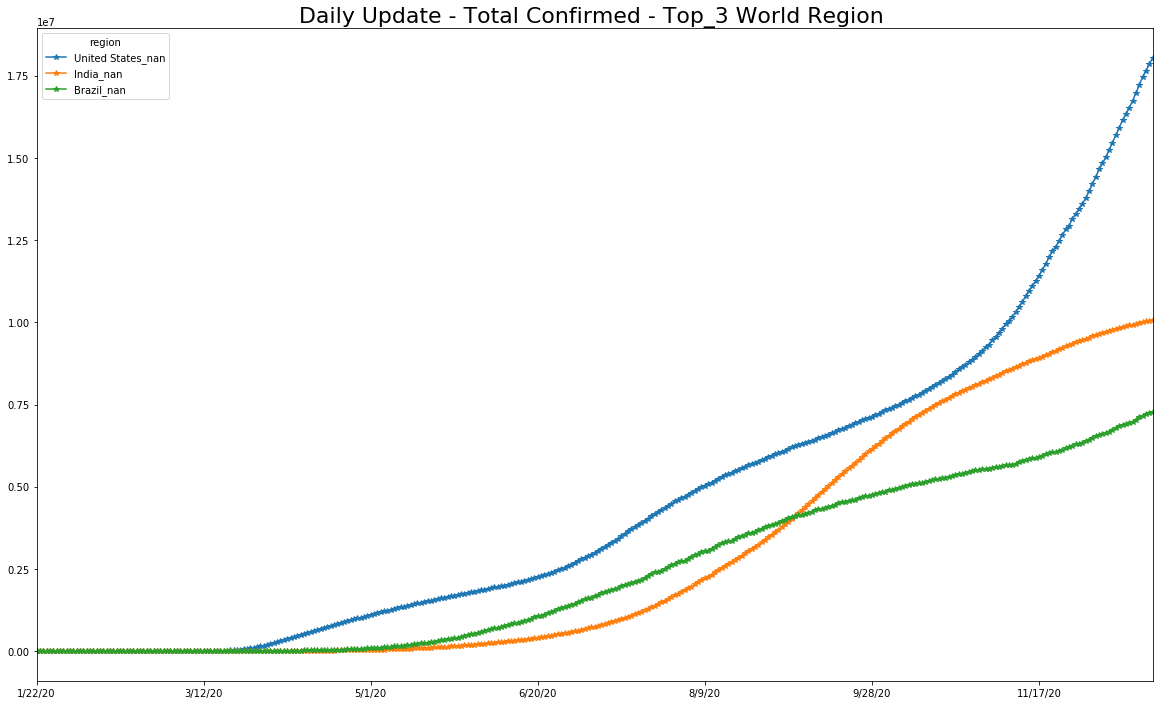

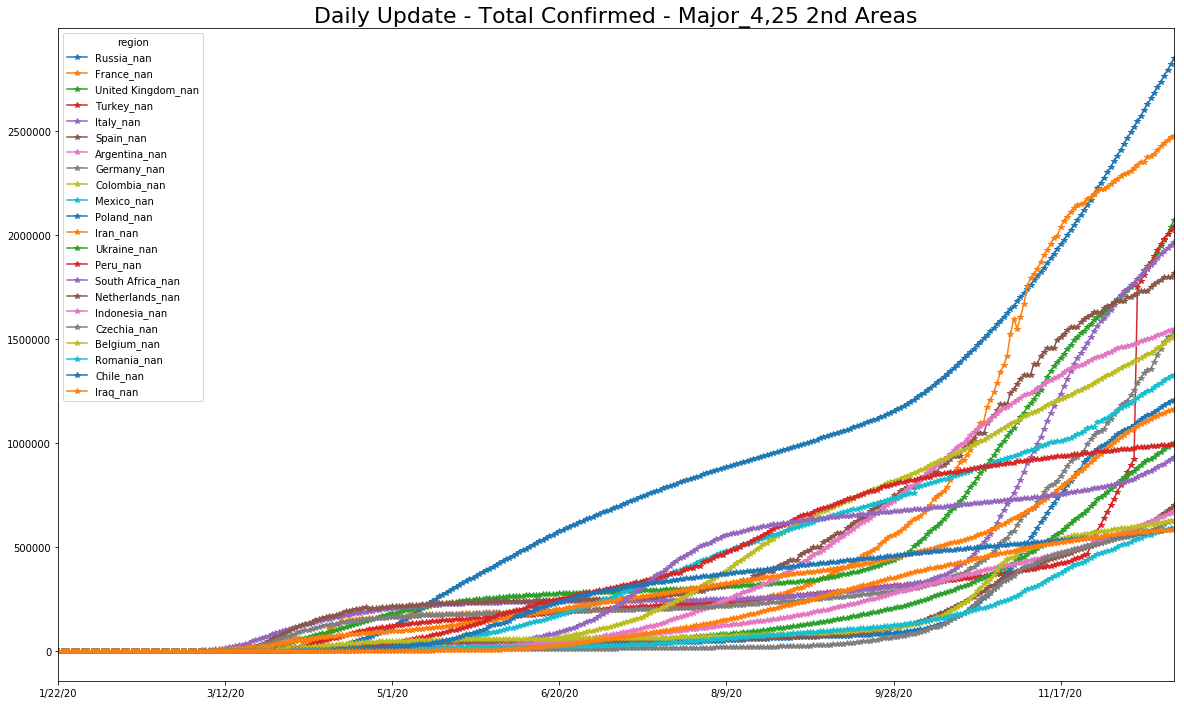

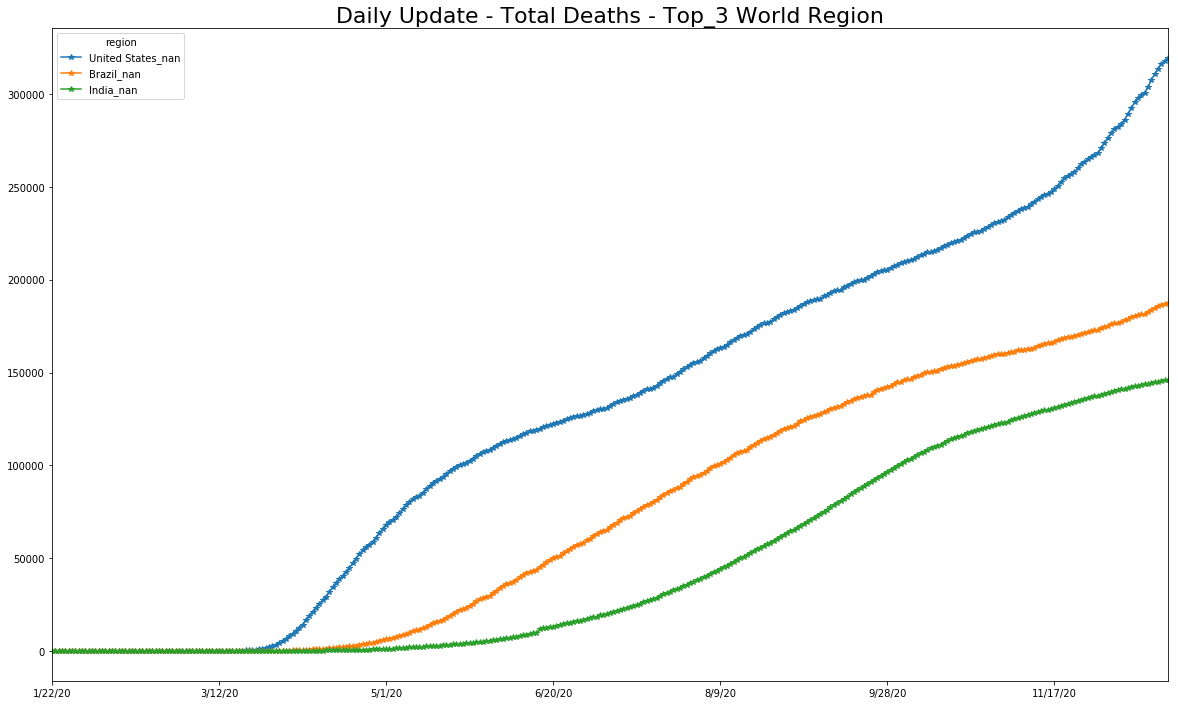

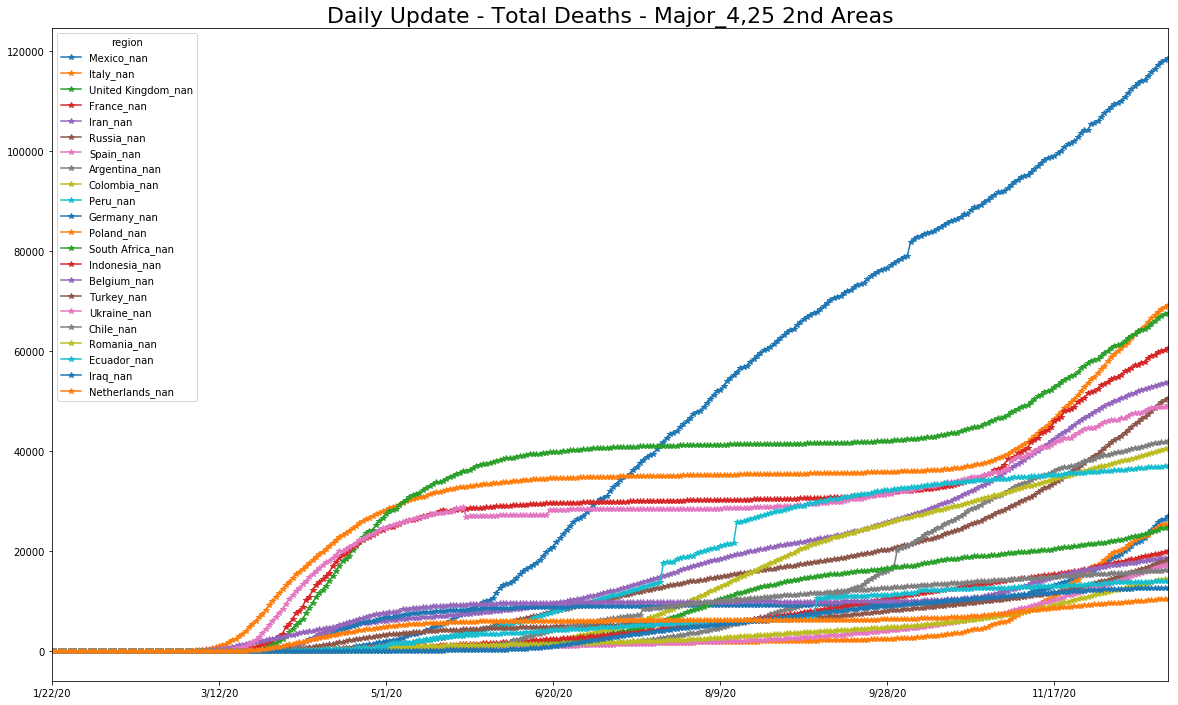

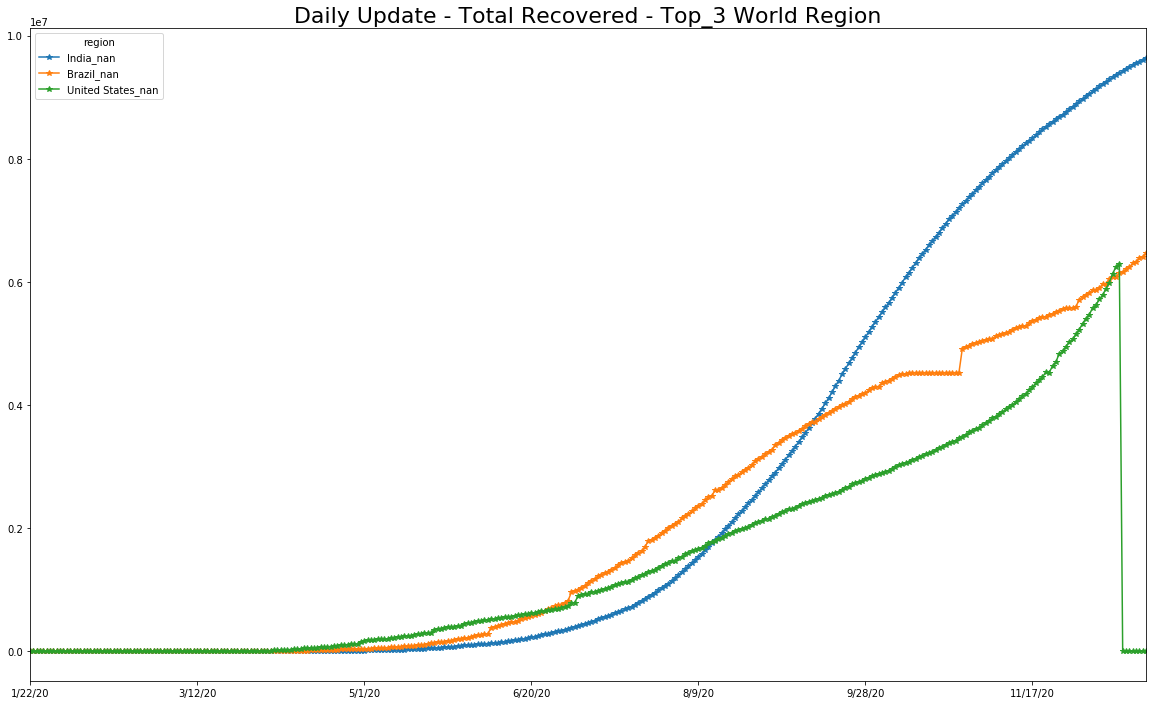

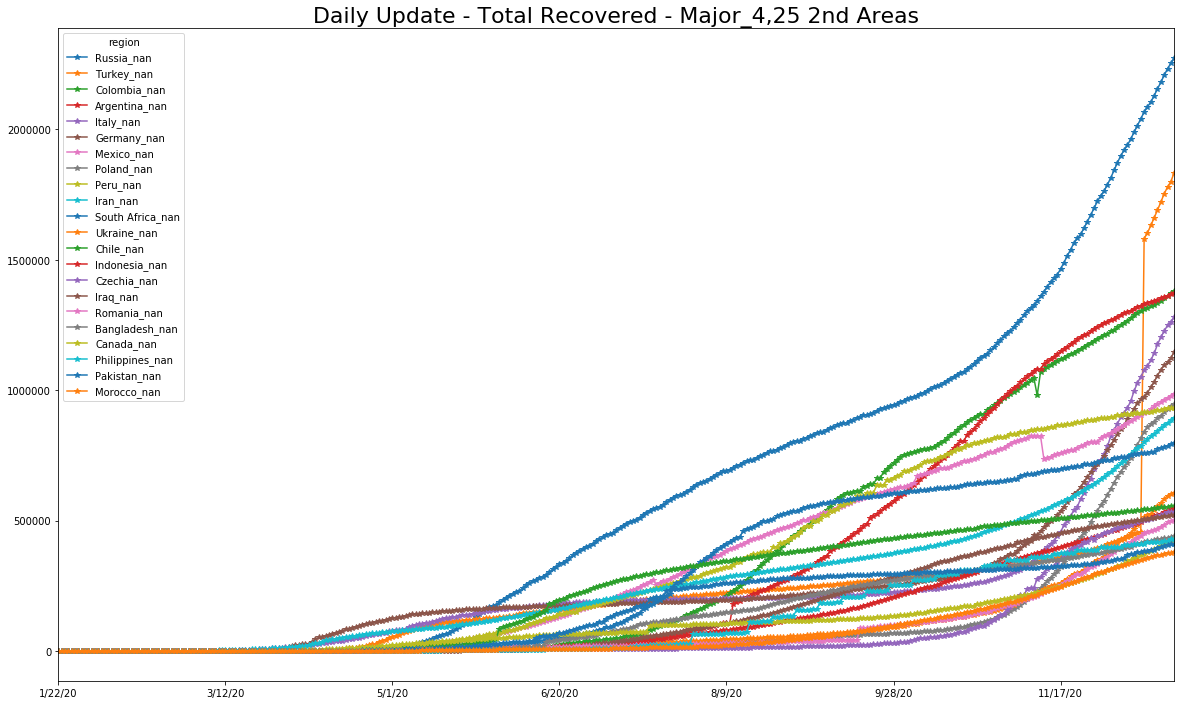

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/12/22


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34984         3752        20770          862         576   
7/16/20            35060         3851        21355          877         607   
7/17/20            35219         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
7/15/20  ...            3492184         1009           14581            0   
7/16/20  ...            3568772         1026           15066            0   
7/17/20  ...            3640660         1037           15607            0   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
7/15/20          10428          381                    7064       1526   
7/16/20          10854          381                    7412       1552   
7/17/20          11191          382                    7764       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 271 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/18/20            49621        52004        94371         7519       16562   
12/19/20            49681        52542        94781         7560       16626   
12/20/20            49817        53003        95203         7577       16644   
12/21/20            50013        53425        95659         7602       16686   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/18/20                      152        1531374       152253   
12/19/20                      152        1537169       153173   
12/20/20                      153        1541285       153825   
12/21/20                      153        1547138       154065   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
12/18/20                                     117                       4712   
12/19/20                                     117                       4748   
12/20/20                                     118                       4771   
12/21/20                                     118                       4789   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
12/18/20  ...           17459296        11950           75675            1   
12/19/20  ...           17655591        12557           75806            1   
12/20/20  ...           17844690        13048           75933            1   
12/21/20  ...           18035209        13477           76048            1   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
12/18/20         109395         1410                  119612       2087   
12/19/20         109781         1411                  121216       2087   
12/20/20         110075         1413                  122643       2087   
12/21/20         110513         1414                  123945       2087   

region    Zambia_nan  Zimbabwe_nan  
12/18/20       18575         12047  
12/19/20       18620         12151  
12/20/20       18716         12325  
12/21/20       18768         12422  

[4 rows x 271 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35060             0             0   
2     2020-07-17  Afghanistan_nan      35219            76             0   
3     2020-07-18  Afghanistan_nan      35279           159             0   
4     2020-07-19  Afghanistan_nan      35453            60           295   
5     2020-07-20  Afghanistan_nan      35493           174           393   
6     2020-07-21  Afghanistan_nan      35605            40           274   
7     2020-07-22  Afghanistan_nan      35717           112           326   
8     2020-07-23  Afghanistan_nan      35918           112           264   
9     2020-07-24  Afghanistan_nan      35978           201           425   
10    2020-07-25  Afghanistan_nan      36026            60           373   
11    2020-07-26  Afghanistan_nan      36147            48           309   
12    2020-07-27  Afghanistan_nan      36253           121           229   
13    2020-07-28  Afghanistan_nan      36358           106           275   
14    2020-07-29  Afghanistan_nan      36463           105           332   
15    2020-07-30  Afghanistan_nan      36532           105           316   
16    2020-07-31  Afghanistan_nan      36665            69           279   
17    2020-08-01  Afghanistan_nan      36700           133           307   
18    2020-08-02  Afghanistan_nan      36701            35           237   
19    2020-08-03  Afghanistan_nan      36737             1           169   
20    2020-08-04  Afghanistan_nan      36773            36            72   
21    2020-08-05  Afghanistan_nan      36820            36            73   
22    2020-08-06  Afghanistan_nan      36928            47           119   
23    2020-08-07  Afghanistan_nan      37006           108           191   
24    2020-08-08  Afghanistan_nan      37046            78           233   
25    2020-08-09  Afghanistan_nan      37083            40           226   
26    2020-08-10  Afghanistan_nan      37153            37           155   
27    2020-08-11  Afghanistan_nan      37260            70           147   
28    2020-08-12  Afghanistan_nan      37336           107           214   
29    2020-08-13  Afghanistan_nan      37422            76           253   
30    2020-08-14  Afghanistan_nan      37497            86           269   
...          ...              ...        ...           ...           ...   
44567 2020-11-23     Zimbabwe_nan       9308            48           174   
44568 2020-11-24     Zimbabwe_nan       9398            88           188   
44569 2020-11-25     Zimbabwe_nan       9508            90           226   
44570 2020-11-26     Zimbabwe_nan       9623           110           288   
44571 2020-11-27     Zimbabwe_nan       9714           115           315   
44572 2020-11-28     Zimbabwe_nan       9822            91           316   
44573 2020-11-29     Zimbabwe_nan       9822           108           314   
44574 2020-11-30     Zimbabwe_nan       9950             0           199   
44575 2020-12-01     Zimbabwe_nan      10129           128           236   
44576 2020-12-02     Zimbabwe_nan      10129           179           307   
44577 2020-12-03     Zimbabwe_nan      10424             0           307   
44578 2020-12-04     Zimbabwe_nan      10547           295           474   
44579 2020-12-05     Zimbabwe_nan      10617           123           418   
44580 2020-12-06     Zimbabwe_nan      10718            70           488   
44581 2020-12-07     Zimbabwe_nan      10839           101           294   
44582 2020-12-08     Zimbabwe_nan      10912           121           292   
44583 2020-12-09     Zimbabwe_nan      11007            73           295   
44584 2020-12-10     Zimbabwe_nan      11081            95           289   
44585 2020-12-11     Zimbabwe_nan      11162            74           242   
44586 2020-12-12     Zimbabwe_nan      11219            81           250   
44587 2020-12-13     Zimbabwe_nan      11246            57  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
44596 2020-12-22  Zimbabwe_nan          0            97           375   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
44596          1064         100.787099         103.112891         109.367934   

       last_day  kalman_prediction  population  infected_rate  min  max  
44596     12422            12588.0    14862924       0.000008  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
44596 2020-12-22  Zimbabwe_nan          0            97           375   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
44596          1064         100.787099         103.112891         109.367934   

       last_day  kalman_prediction  population  infected_rate  min  max  
44596     12422            12588.0    14862924       0.000008  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
43628  2020-12-20  Zimbabwe_nan      12325           104           402   
43629  2020-12-21  Zimbabwe_nan      12422           174           459   
43630  2020-12-22  Zimbabwe_nan          0            97           375   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
43628           932         100.863368         103.421653         108.307425   
43629          1079         101.432063         103.868279         109.594611   
43630          1064         100.787099         103.112891         109.367934   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
43628                12151  ...    14862924       0.000008  NaN  NaN   
43629                12325  ...    14862924       0.000008  NaN  NaN   
43630                12422  ...    14862924       0.000008  NaN  NaN   

       population_percentage : infected_rate confirmed  \
43628                                         0.000818   
43629                                         0.000829   
43630                                         0.000836   

       population_percentage : factor 9/10 infected_rate confirmed  \
43628                                           0.008176             
43629                                           0.008293             
43630                                           0.008358             

       delta : new_cases  delta : new_cases per 1M hab  \
43628              136.0                      9.150286   
43629              132.0                      8.881160   
43630              166.0                     11.168731   

       delta : roling 7day AVG  \
43628               133.142857   
43629               154.142857   
43630               152.000000   

       delta : aprox 14-day case notification rate per 100k hab  
43628                                          12.541274         
43629                                          14.519350         
43630                                          14.317506         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse           mae
261  United States_nan  2.088828e+12  1.445278e+06  134233.89375


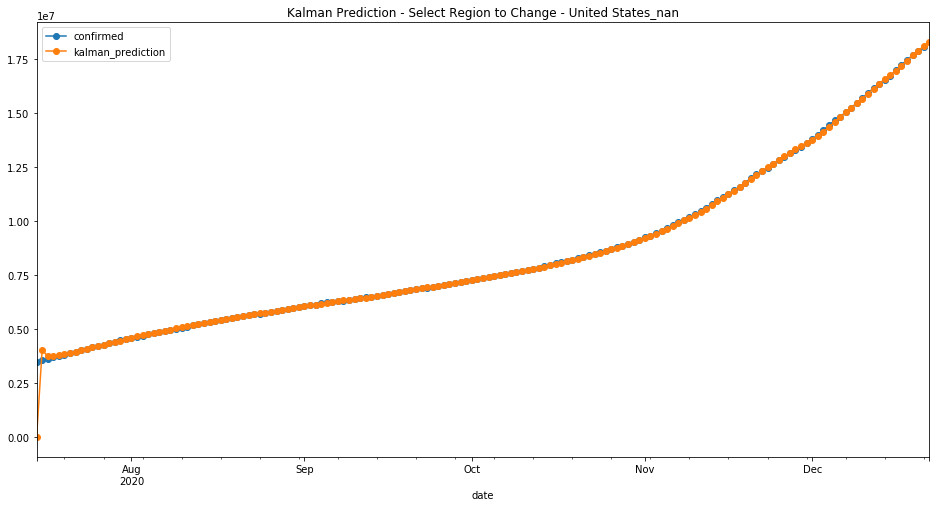

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse          mae
211  Russia_nan  5.180776e+10  227613.17453  20182.24375


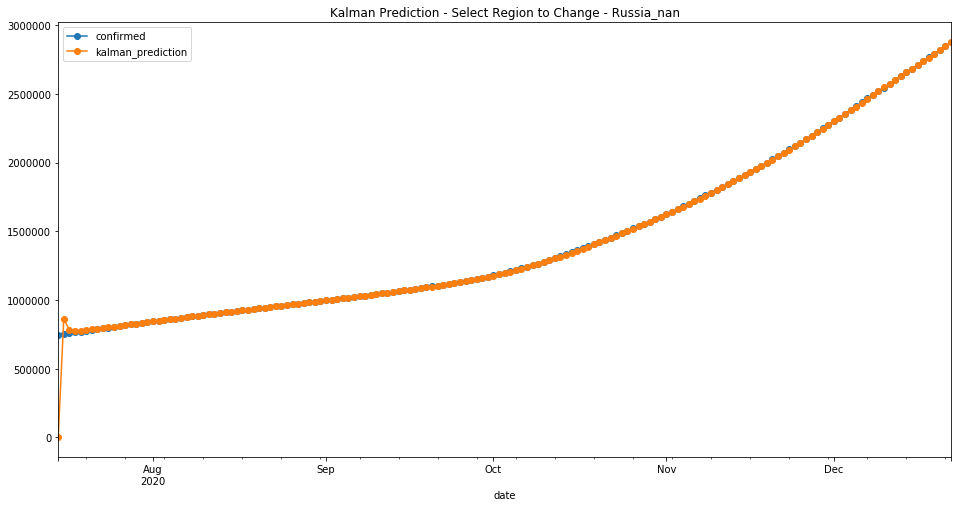

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse          mae
30  Brazil_nan  3.364712e+11  580061.345057  63259.10625


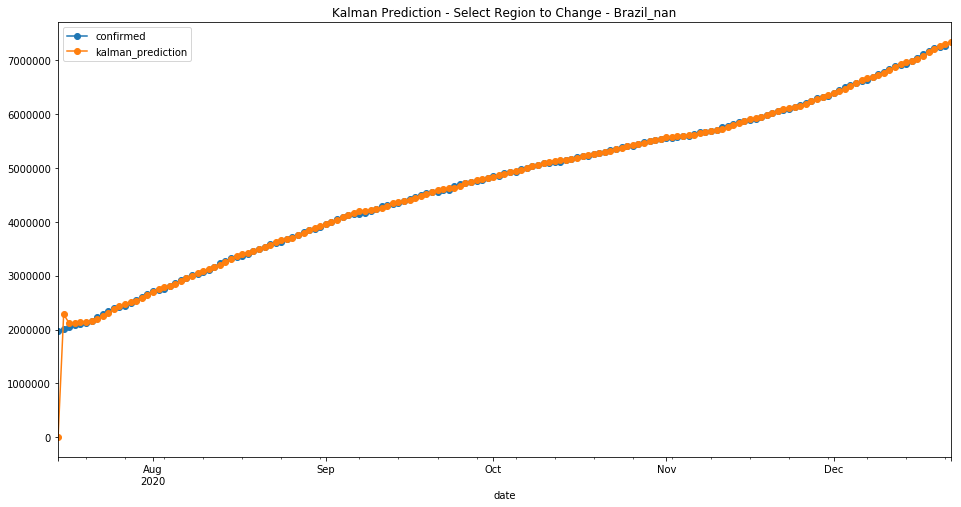

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse      mae
260  United Kingdom_nan  2.753961e+10  165950.639877  16230.2


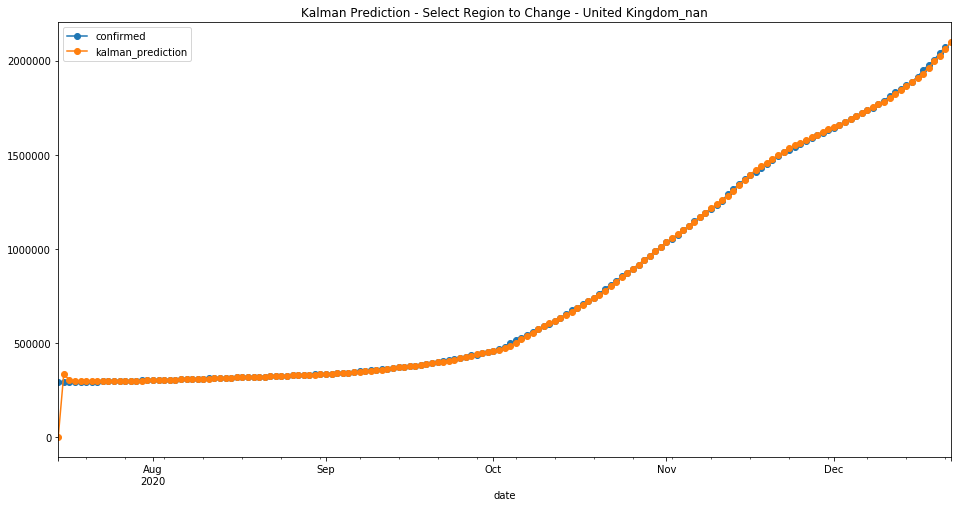

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_z40tdwf
  JVM stdout: /tmp/tmp_z40tdwf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_z40tdwf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    2 months and 23 days
H2O_cluster_name:           H2O_from_python_unknownUser_szhrgy
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-12-14
last_train_date= 2020-12-21
first_bootstrap_date= 2020-12-13
boost_bootstrap_date= 2020-12-18
first_test_date= 2020-12-12
last_test_date= 2020-12-22
first_valid_date= 2020-12-20


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   48502.0      48527 2020-12-13  Afghanistan_nan
1   48767.0      48718 2020-12-14  Afghanistan_nan
2   48958.0      48952 2020-12-15  Afghanistan_nan
3   49211.0      49161 2020-12-16  Afghanistan_nan
4   49423.0      49378 2020-12-17  Afghanistan_nan
5   49658.0      49621 2020-12-18  Afghanistan_nan
6   49900.0      49681 2020-12-19  Afghanistan_nan
7   49976.0      49817 2020-12-20  Afghanistan_nan
8   50123.0      50013 2020-12-21  Afghanistan_nan
9   50289.0          0 2020-12-22  Afghanistan_nan
10  48449.0      48530 2020-12-13      Albania_nan
11  49252.0      49191 2020-12-14      Albania_nan
12  49935.0      50000 2020-12-15      Albania_nan
13  50729.0      50637 2020-12-16      Albania_nan
14  51352.0      51424 2020-12-17      Albania_nan
15  52133.0      52004 2020-12-18      Albania_nan
16  52695.0      52542 2020-12-19      Albania_nan
17  53239.0      53003 2020-12-20      Albania_nan
18  53667.0      53425 2020-12-21      Albania_nan
19  54046.0          0 2020-12-22      Albania_nan
20  92327.0      92102 2020-12-13      Algeria_nan
21  92765.0      92597 2020-12-14      Algeria_nan
22  93229.0      93065 2020-12-15      Algeria_nan
23  93667.0      93507 2020-12-16      Algeria_nan
24  94093.0      93933 2020-12-17      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  195369.0     195422 2020-12-18  Azerbaijan_nan
176  199295.0     199127 2020-12-19  Azerbaijan_nan
177  202992.0     202088 2020-12-20  Azerbaijan_nan
178  205914.0     203593 2020-12-21  Azerbaijan_nan
179  207197.0          0 2020-12-22  Azerbaijan_nan
180    7731.0       7659 2020-12-13     Bahamas_nan
181    7766.0       7674 2020-12-14     Bahamas_nan
182    7778.0       7698 2020-12-15     Bahamas_nan
183    7792.0       7714 2020-12-16     Bahamas_nan
184    7821.0       7725 2020-12-17     Bahamas_nan
185    7839.0       7733 2020-12-18     Bahamas_nan
186    7849.0       7733 2020-12-19     Bahamas_nan
187    7857.0       7746 2020-12-20     Bahamas_nan
188    7851.0       7765 2020-12-21     Bahamas_nan
189    7861.0          0 2020-12-22     Bahamas_nan
190   88975.0      89143 2020-12-13     Bahrain_nan
191   89158.0      89268 2020-12-14     Bahrain_nan
192   89277.0      89444 2020-12-15     Bahrain_nan
193   89454.0      89600 2020-12-16     Bahrain_nan
194   89601.0      89743 2020-12-17     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  160121.0     160295 2020-12-13  Belarus_nan
221  162117.0     162148 2020-12-14  Belarus_nan
222  163995.0     164059 2020-12-15  Belarus_nan
223  165921.0     165897 2020-12-16  Belarus_nan
224  167754.0     167731 2020-12-17  Belarus_nan
225  169597.0     169648 2020-12-18  Belarus_nan
226  171510.0     171579 2020-12-19  Belarus_nan
227  173429.0     173523 2020-12-20  Belarus_nan
228  175375.0     175416 2020-12-21  Belarus_nan
229  177263.0          0 2020-12-22  Belarus_nan
230  605229.0     608137 2020-12-13  Belgium_nan
231  610084.0     609211 2020-12-14  Belgium_nan
232  610751.0     611422 2020-12-15  Belgium_nan
233  613576.0     615058 2020-12-16  Belgium_nan
234  617308.0     618204 2020-12-17  Belgium_nan
235  620483.0     621039 2020-12-18  Belgium_nan
236  623307.0     623760 2020-12-19  Belgium_nan
237  626172.0     625930 2020-12-20  Belgium_nan
238  628562.0     626911 2020-12-21  Belgium_nan
239  629334.0          0 2020-12-22  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2409574548.540484
# MSE on the validation data =  4339945469393.3555
# R^2 on the training data =  0.9994580217837464
# R^2 on the validation data =  0.4668524219604039


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1608616988714_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           20945410.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       22.0       23.0       22.99      2869.0      3398.0     3276.324



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2409574548.540484
RMSE: 49087.417415672666
MAE: 5144.460371719508
RMSLE: 0.24446161293429988
Mean Residual Deviance: 2409574548.540484

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 4339945469393.3555
RMSE: 2083253.577794445
MAE: 536449.3036280992
RMSLE: 7.289785125736102
Mean Residual Deviance: 4339945469393.3555

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-12-22 06:03:18   0.100 sec              0.0            NaN   
1     2020-12-22 06:03:18   0.598 sec              1.0   83487.433253   
2     2020-12-22 06:03:18   0.863 sec              2.0   86304.351112   
3     2020-12-22 06:03:19   0.999 sec              3.0   72851.274460   
4     2020-12-22 06:03:19   1.151 sec              4.0   67131.528590   
5     2020-12-22 06:03:19   1.447 sec              5.0   69459.715666   
6     2020-12-22 06:03:19   1.565 sec              6.0   73255.398109   
7     2020-12-22 06:03:19   1.679 sec              7.0   71626.133173   
8     2020-12-22 06:03:19   1.815 sec              8.0   71161.679424   
9     2020-12-22 06:03:19   1.901 sec              9.0   70627.939678   
10    2020-12-22 06:03:20   2.007 sec             10.0   65863.608206   
11    2020-12-22 06:03:20   2.119 sec             11.0   69311.541874   
12    2020-12-22 06:03:20   2.262 sec             12.0   61989.832795   
13    2020-12-22 06:03:20   2.343 sec             13.0   60775.435727   
14    2020-12-22 06:03:20   2.424 sec             14.0   55674.029863   
15    2020-12-22 06:03:20   2.508 sec             15.0   56044.566375   
16    2020-12-22 06:03:20   2.628 sec             16.0   51027.446849   
17    2020-12-22 06:03:20   2.710 sec             17.0   51913.212302   
18    2020-12-22 06:03:20   2.798 sec             18.0   48535.911536   
19    2020-12-22 06:03:20   2.887 sec             19.0   49090.749897   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   15649.193741       6.970152e+09     2.203112e+06   559415.920291   
2   15597.658660       7.448441e+09     2.173194e+06   549907.203591   
3   13484.922046       5.307308e+09     2.162681e+06   545937.048687   
4   12873.631761       4.506642e+09     2.158384e+06   544043.879333   
5   12582.924185       4.824652e+09     2.146377e+06   542670.984195   
6   12117.396535       5.366353e+09     2.142936e+06   540377.648798   
7   11405.994038       5.130303e+09     2.144126e+06   540831.054031   
8   11283.959693       5.063985e+09     2.144392e+06   540669.659670   
9   10937.649395       4.988306e+09     2.134343e+06   540045.729311   
10  10386.497944       4.338015e+09     2.126495e+06   539136.882793   
11  10219.684363       4.804090e+09     2.128338e+06   539027.972719   
12   9535.481247       3.842739e+09     2.129639e+06   538747.907692   
13   9273.704108       3.693654e+09     2.114512e+06   538969.649596   
14   8820.205102       3.099598e+09     2.094863e+06   538396.981102   
15   8593.445714       3.140993e+09     2.094841e+06   538397.823134   
16   8286.215399       2.603800e+09     2.097715e+06   538367.143560   
17   8134.568508       2.694982e+09     2.108403e+06   540247.963803   
18   7900.641834       2.355735e+09     2.110806e+06   540213.736441   
19   7845.305331       2.409902e+09     2.098071e+06   540282.942773   

    validation_deviance  
0                   NaN  
1          4.853701e+12  
2          4.722772e+12  
3          4.677188e+12  
4          4.658623e+12  
5          4.606934e+12  
6          4.592175e+12  
7          4.597274e+12  
8          4.598418e+12  
9          4.555421e+12  
10         4.521980e+12  
11         4.529822e+12  
12         4.535362e+12  
13         4.471160e+12  
14         4.388451e+12  
15         4.388360e+12  
16         4.400407e+12  
17         4.445365e+12  
18         4.455502e+12  
19         4.401902e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         4.582324e+18           1.000000    0.361778
1            last_day         3.672669e+18           0.801486    0.289960
2              region         1.806120e+18           0.394149    0.142595
3        7_day_change         1.126423e+18           0.245819    0.088932
4        3_day_change         7.388253e+17           0.161234    0.058331
5        1_day_change         3.820528e+17           0.083375    0.030163
6       infected_rate         2.263148e+17           0.049389    0.017868
7                 max         4.205484e+16           0.009178    0.003320
8                 min         2.793457e+16           0.006096    0.002205
9   7_day_change_rate         2.441206e+16           0.005327    0.001927
10  3_day_change_rate         2.383179e+16           0.005201    0.001882
11  1_day_change_rate         1.316201e+16           0.002872    0.001039

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         4.582324e+18           1.000000    0.361778
1            last_day         3.672669e+18           0.801486    0.289960
2              region         1.806120e+18           0.394149    0.142595
3        7_day_change         1.126423e+18           0.245819    0.088932
4        3_day_change         7.388253e+17           0.161234    0.058331
5        1_day_change         3.820528e+17           0.083375    0.030163
6       infected_rate         2.263148e+17           0.049389    0.017868
7                 max         4.205484e+16           0.009178    0.003320
8                 min         2.793457e+16           0.006096    0.002205
9   7_day_change_rate         2.441206e+16           0.005327    0.001927
10  3_day_change_rate         2.383179e+16           0.005201    0.001882
11  1_day_change_rate         1.316201e+16           0.002872    0.001039

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


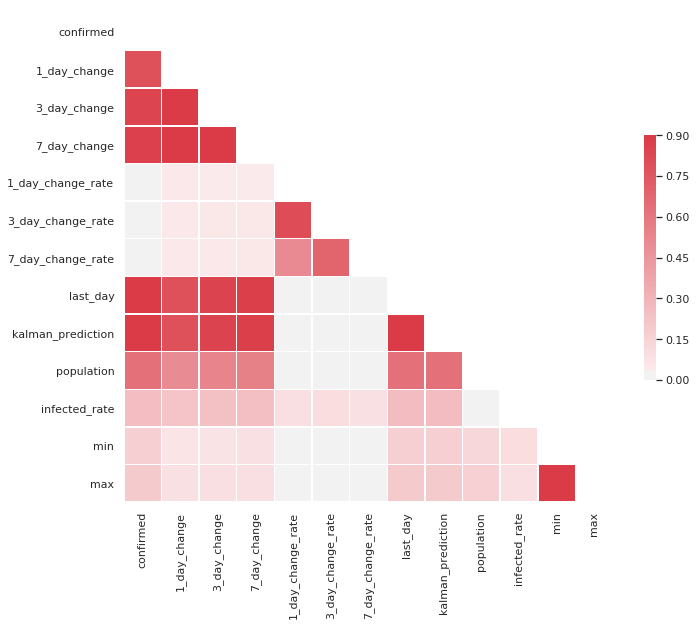

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.789622
3_day_change         0.847786
7_day_change         0.867888
1_day_change_rate    0.028039
3_day_change_rate    0.029120
7_day_change_rate    0.024033
last_day             0.989050
kalman_prediction    0.989405
population           0.627438
infected_rate        0.260244
min                  0.172820
max                  0.193692
Name: confirmed, dtype: float64


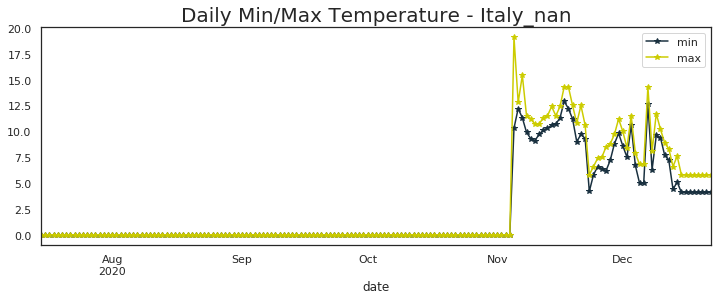

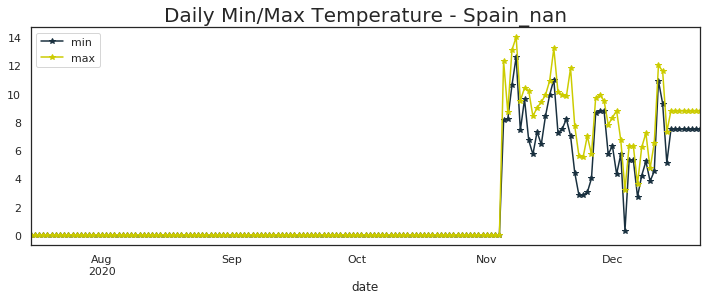

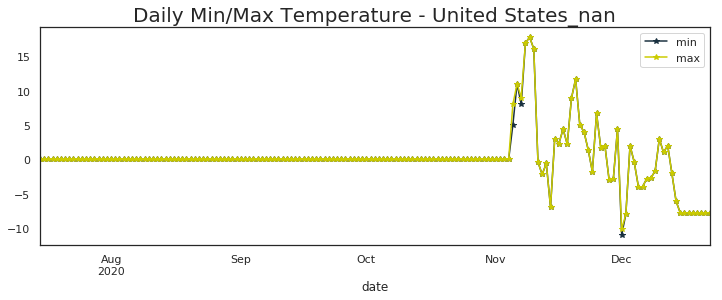

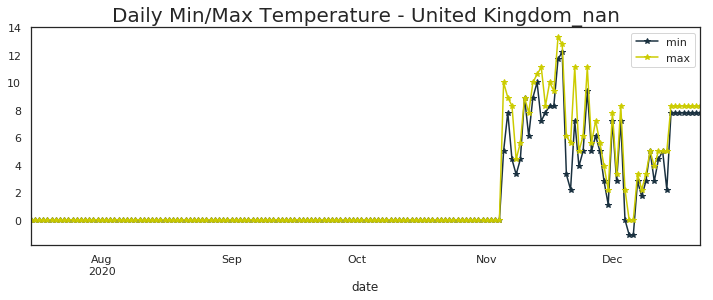

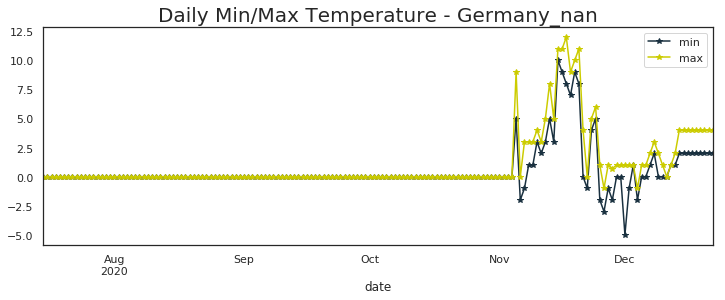

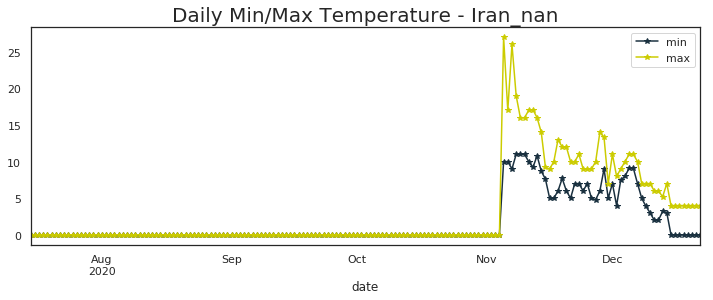

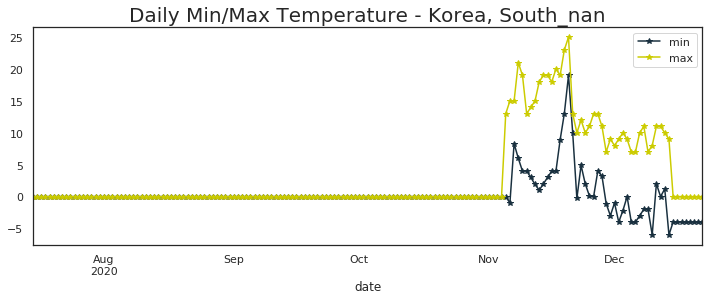

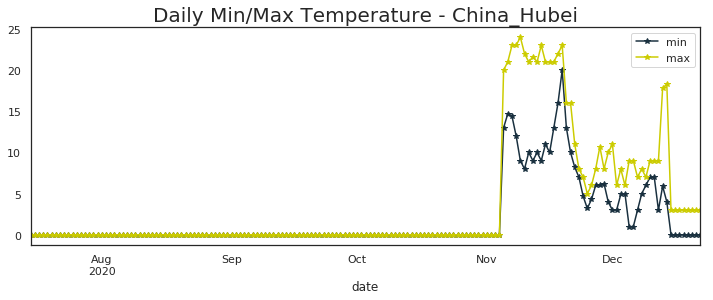

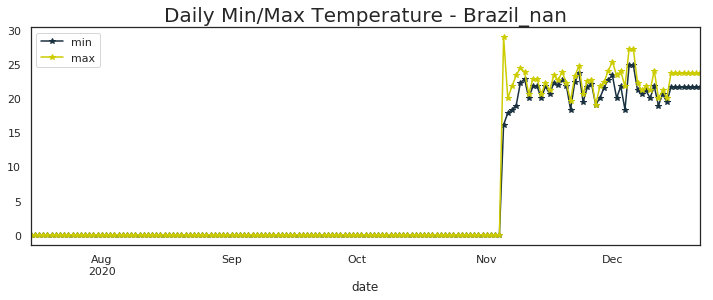

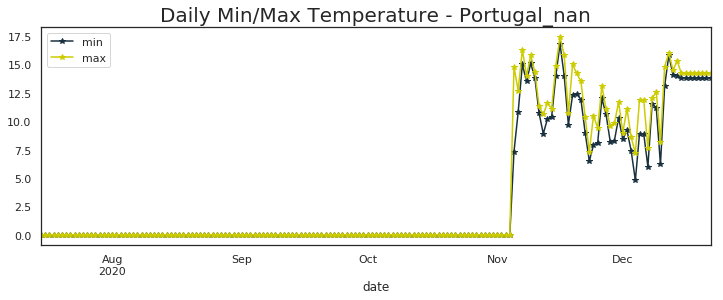

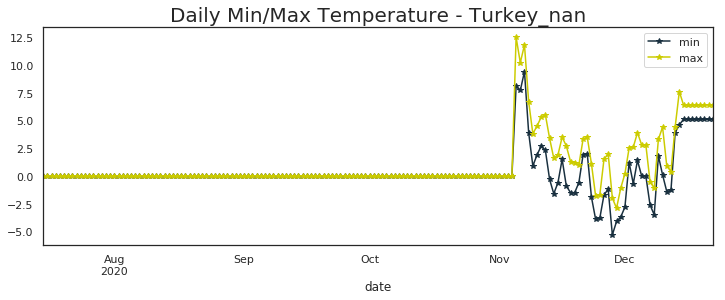

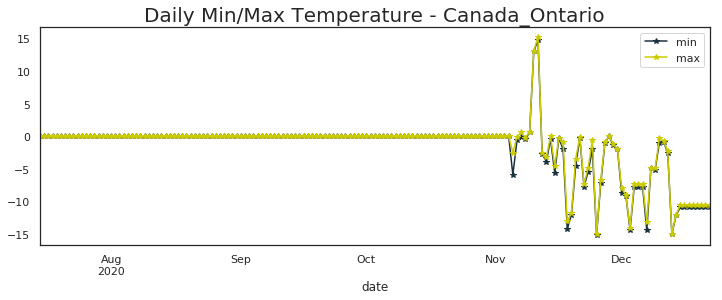

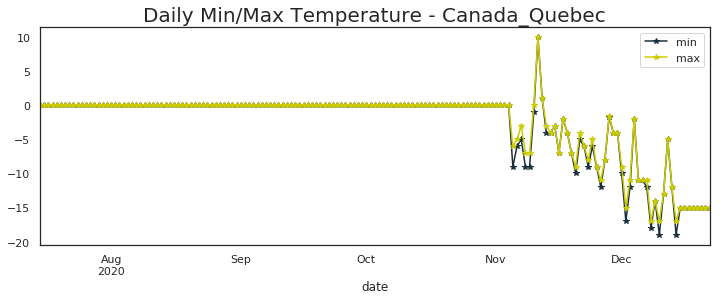

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
Russia_nan                   0.0   4.0
France_nan                  12.1  13.3
United Kingdom_nan          12.2  13.3
Turkey_nan                   9.4  12.5
Italy_nan                   12.9  19.1
Spain_nan                   12.6  14.0
Argentina_nan                0.0   0.0
Germany_nan                 10.0  12.0
Colombia_nan                 0.0   0.0
Mexico_nan                  15.1  15.1
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
Ukraine_nan                  0.0   0.0
Peru_nan                    24.6  29.9
South Africa_nan             0.0   0.0
Netherlands_nan             14.4  16.1
Indonesia_nan                0.0   0.0
Czechia_nan                  0.0   0.0
Belgium_nan                 13.7  14.5
Romania_nan                 

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

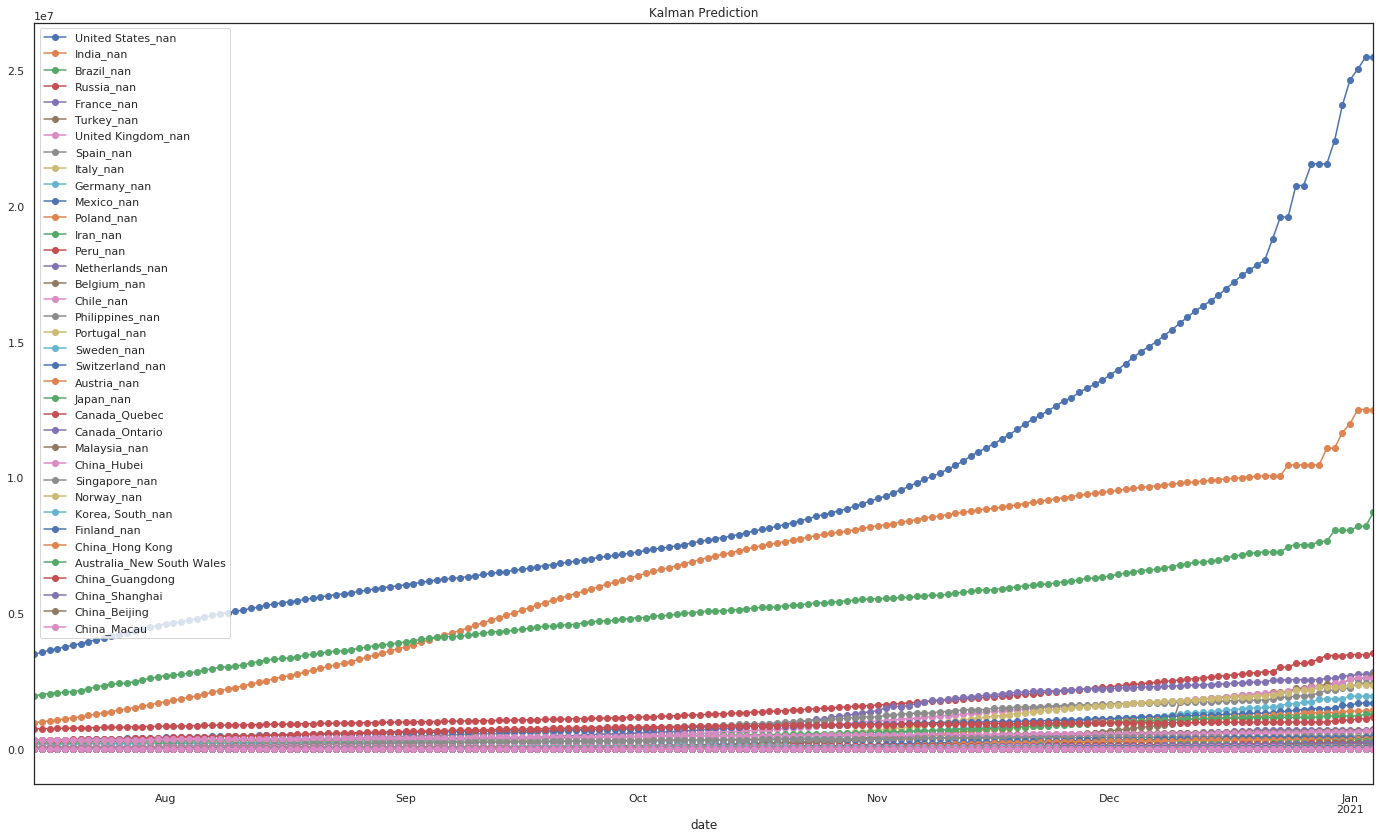

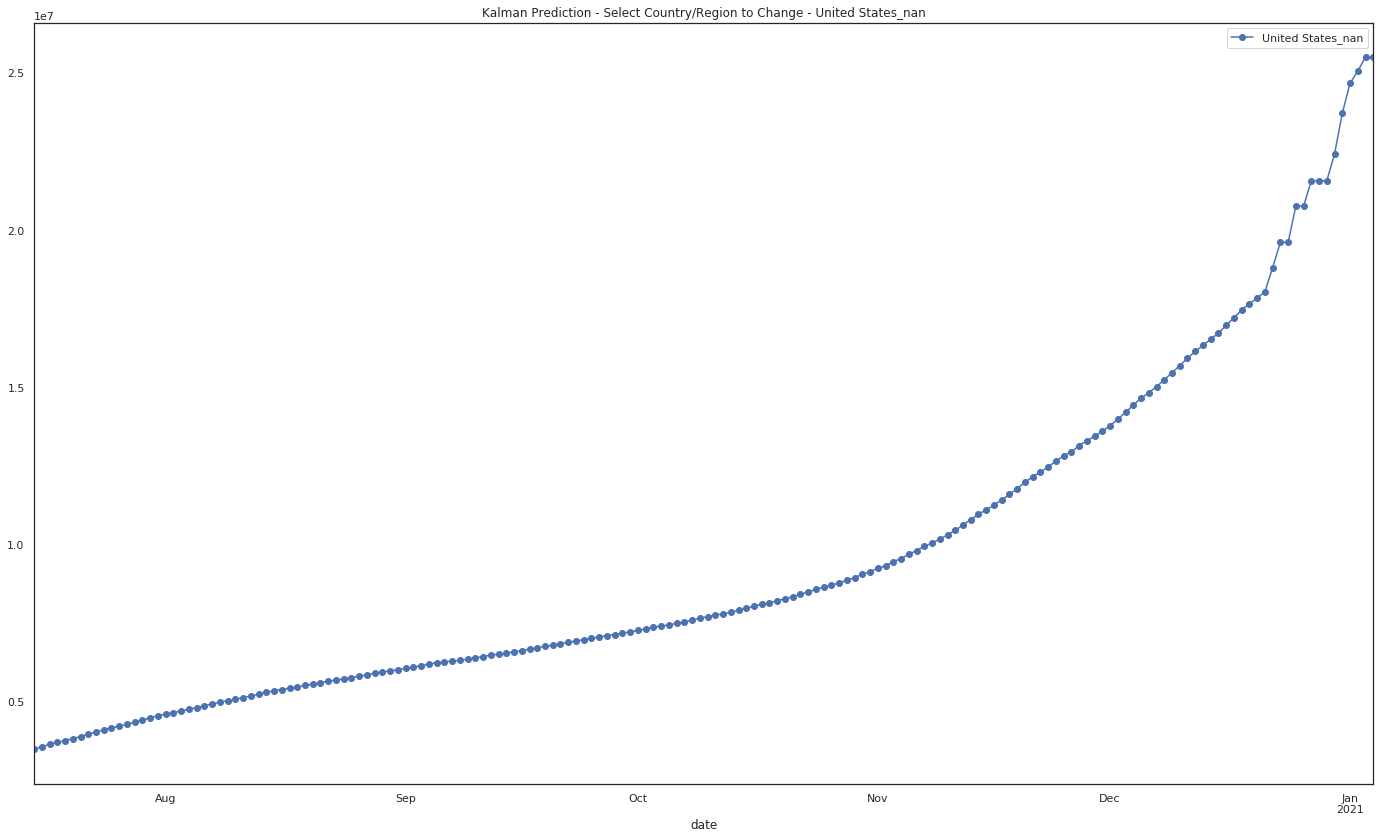

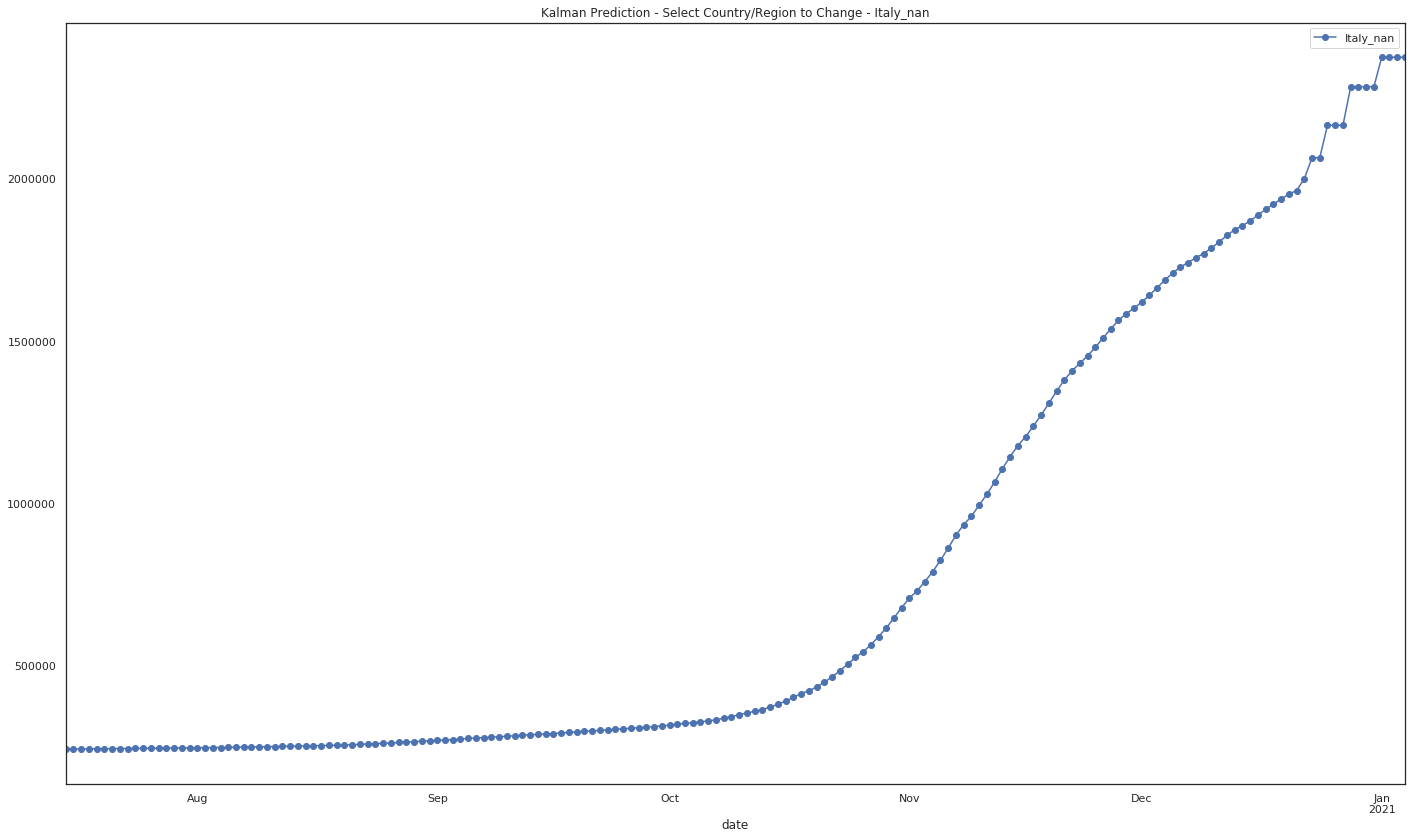

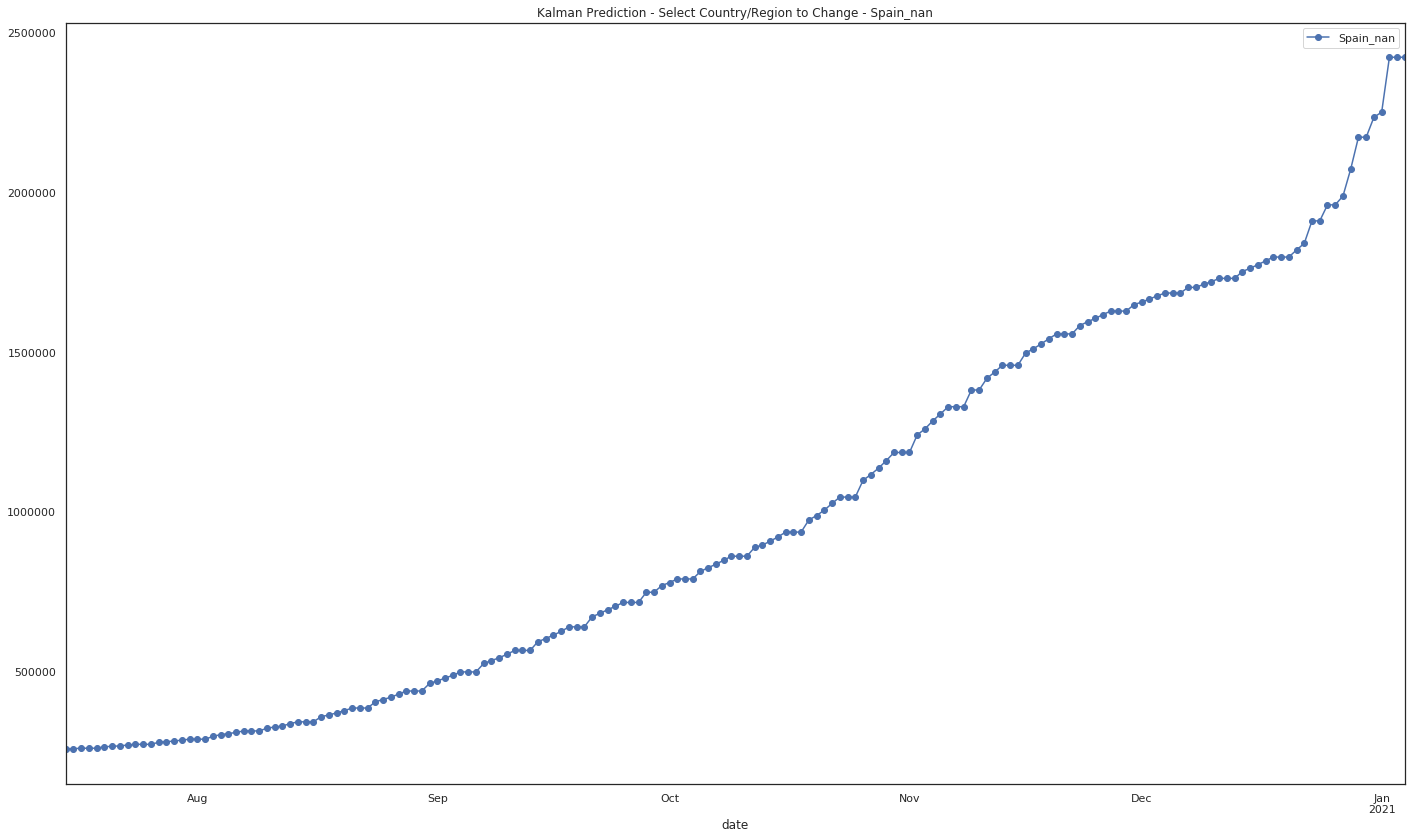

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


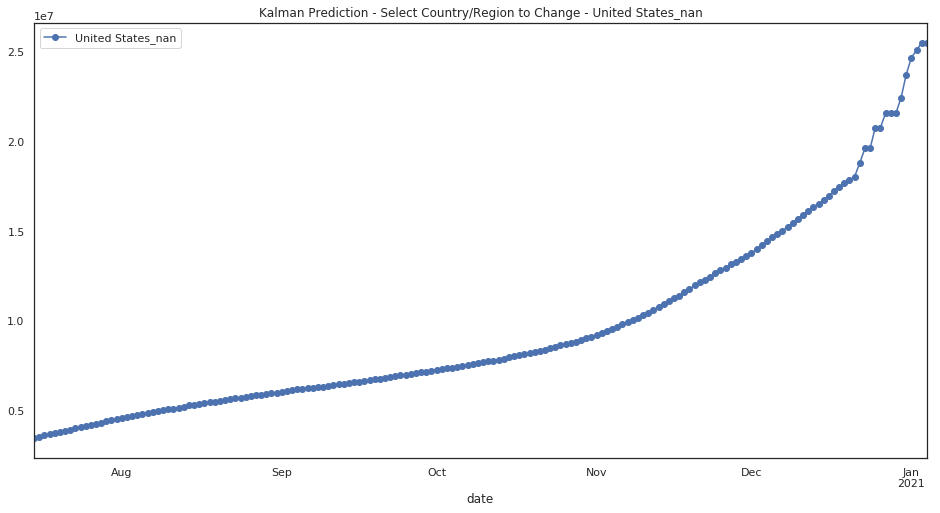

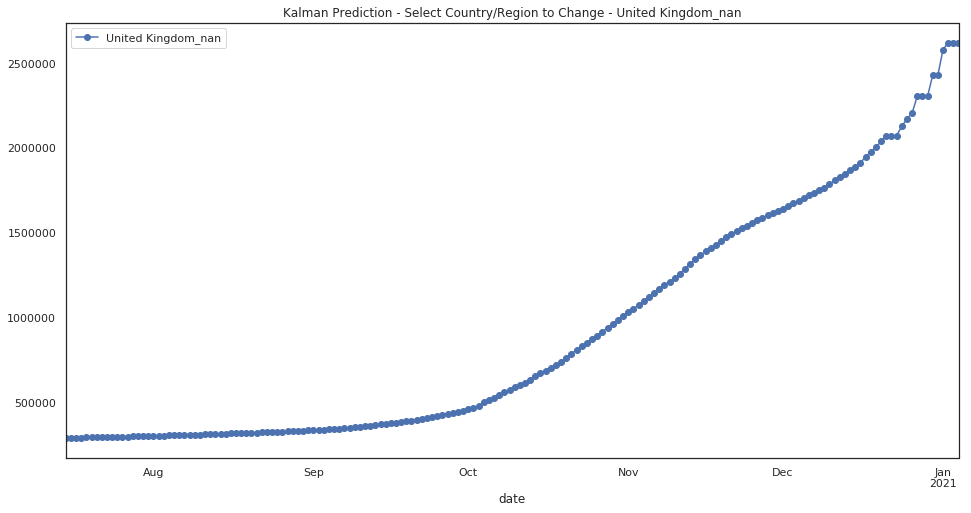

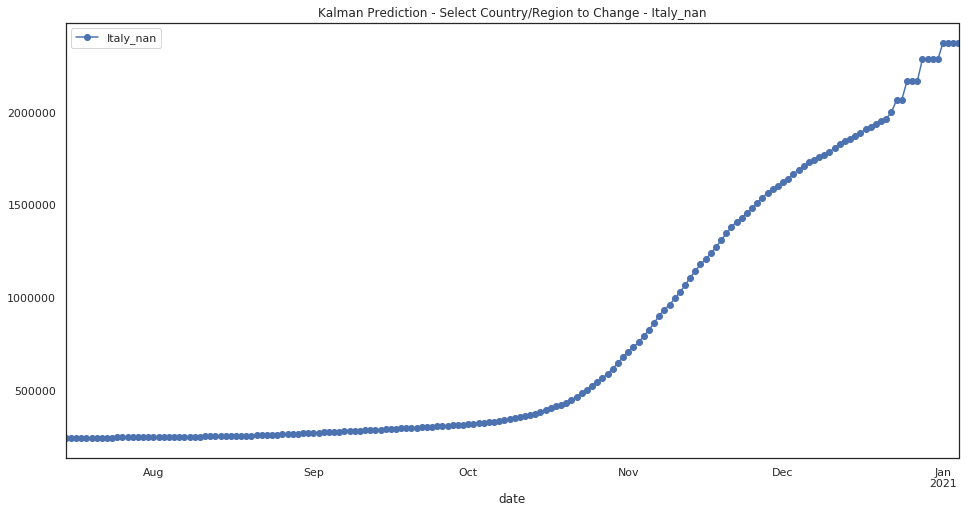

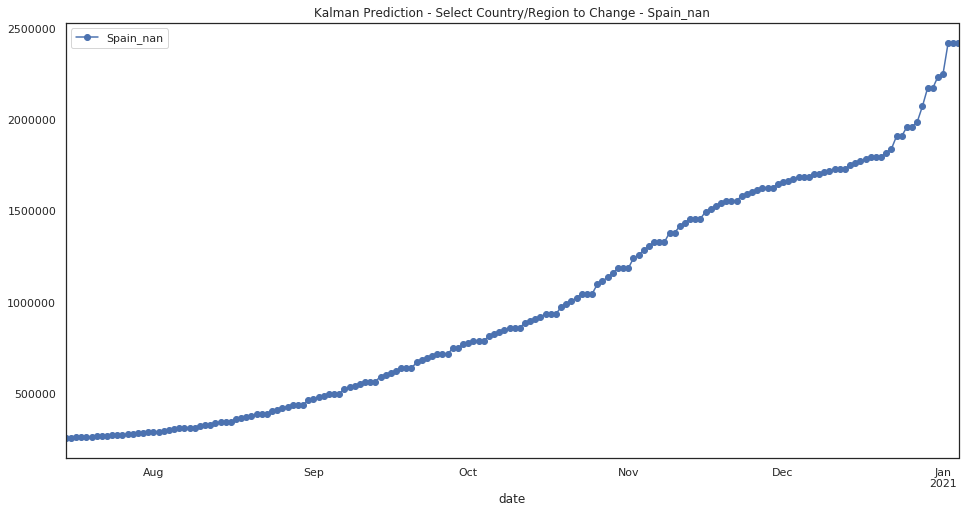

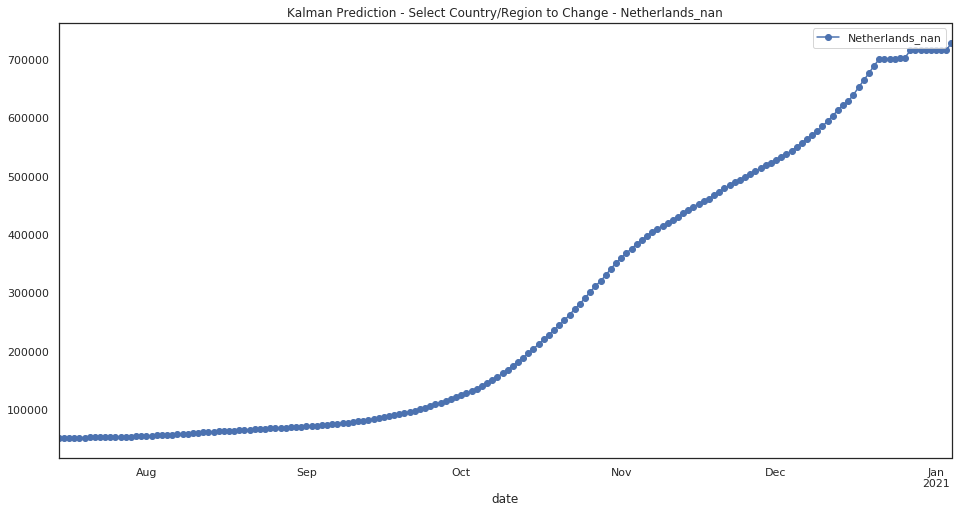

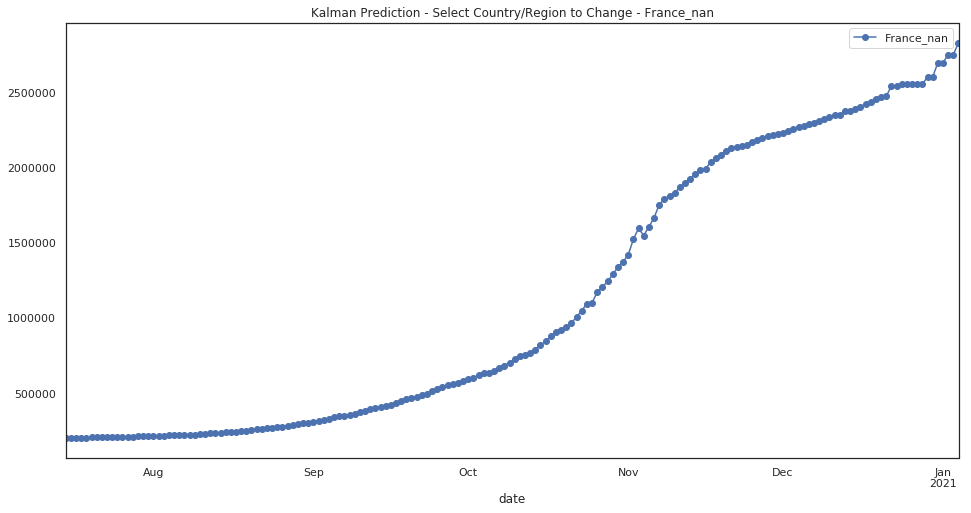

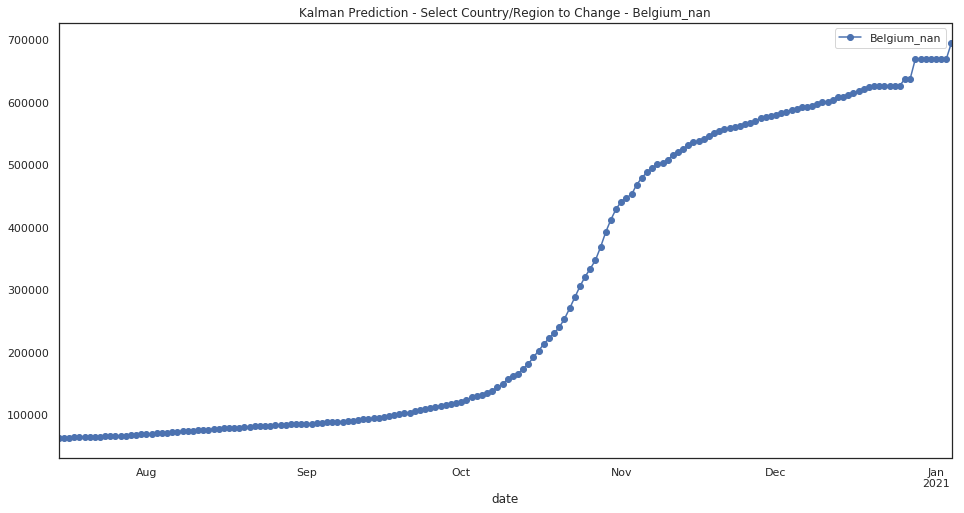

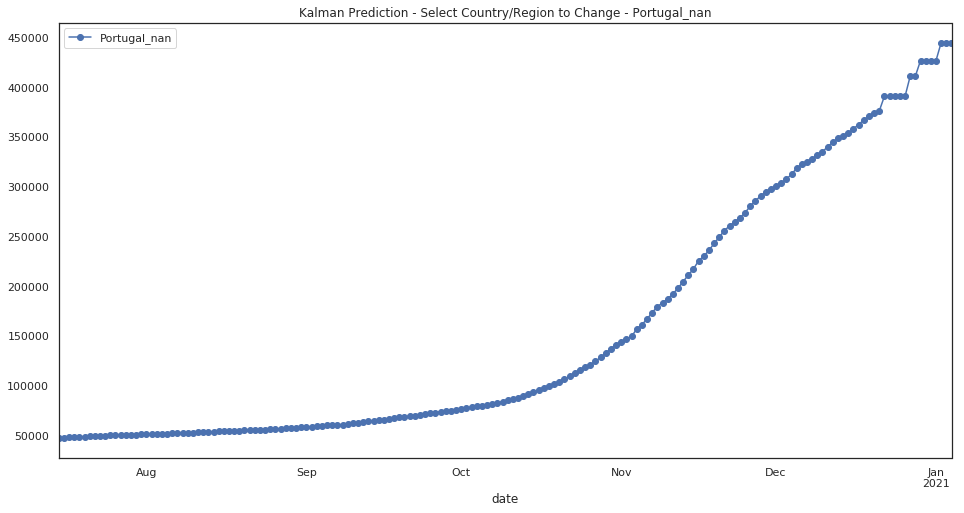

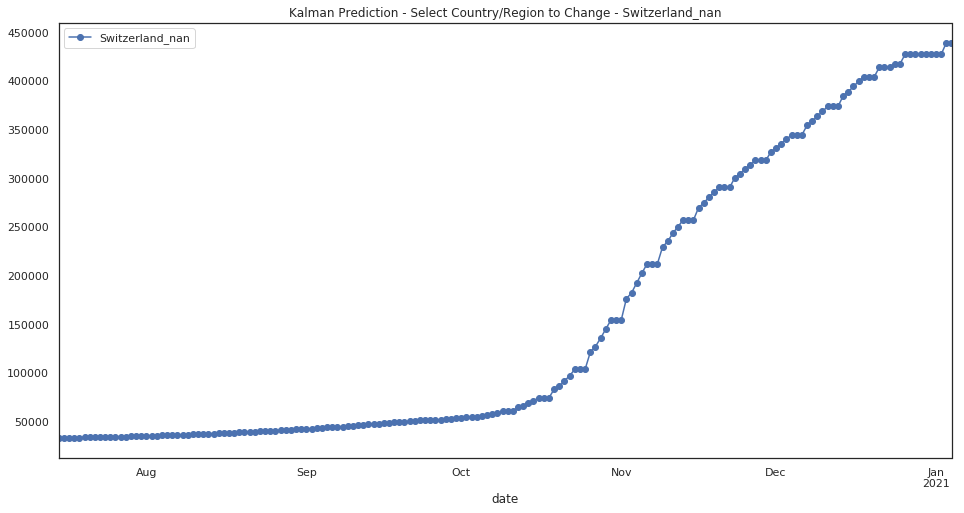

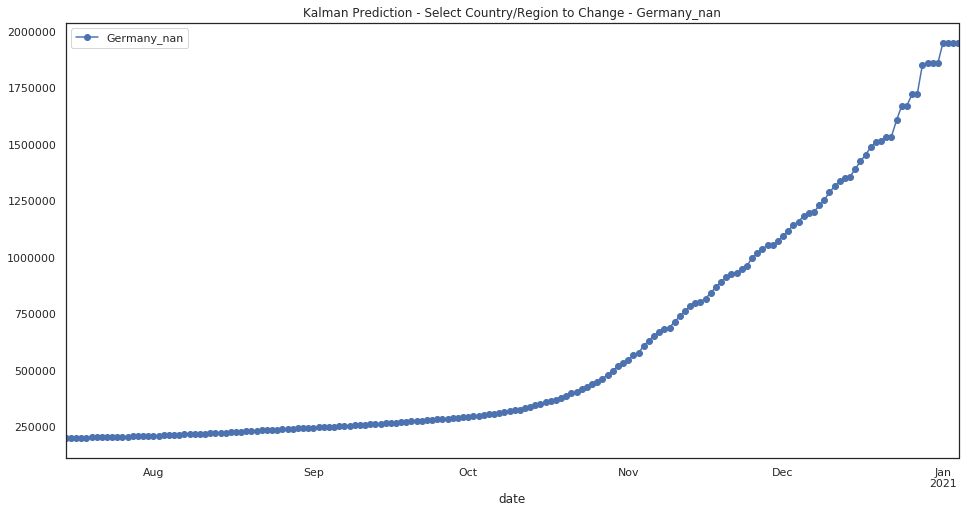

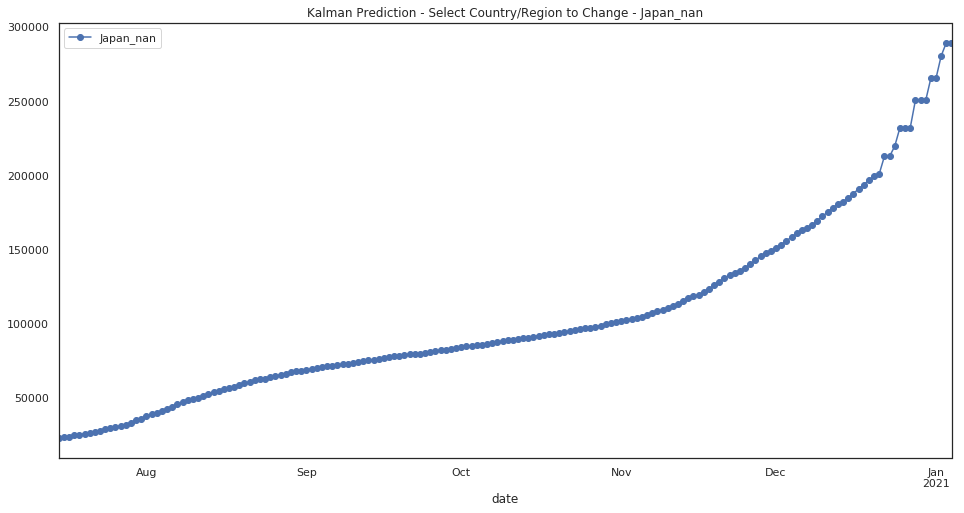

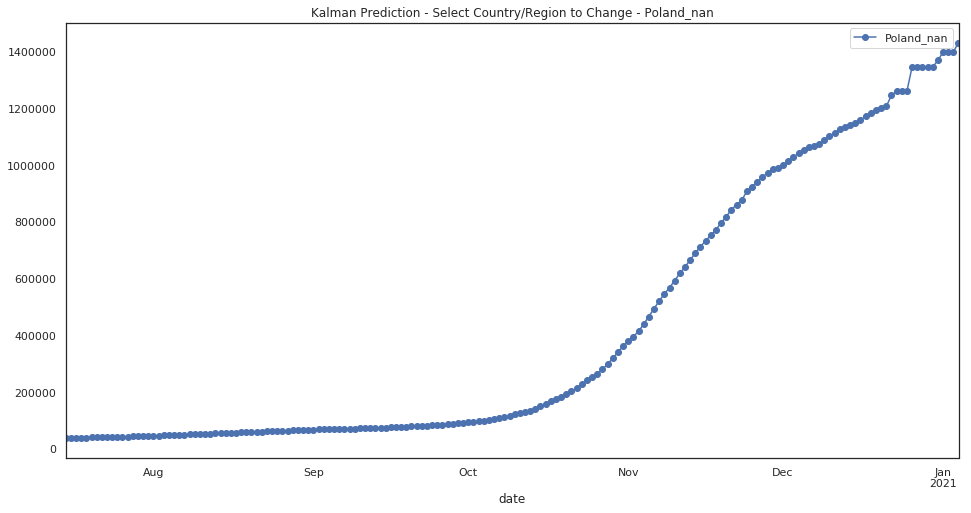

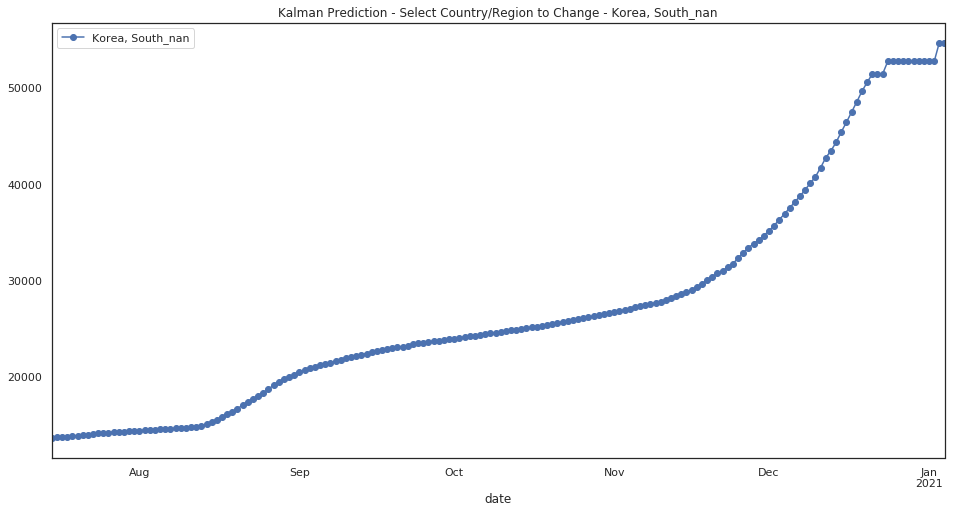

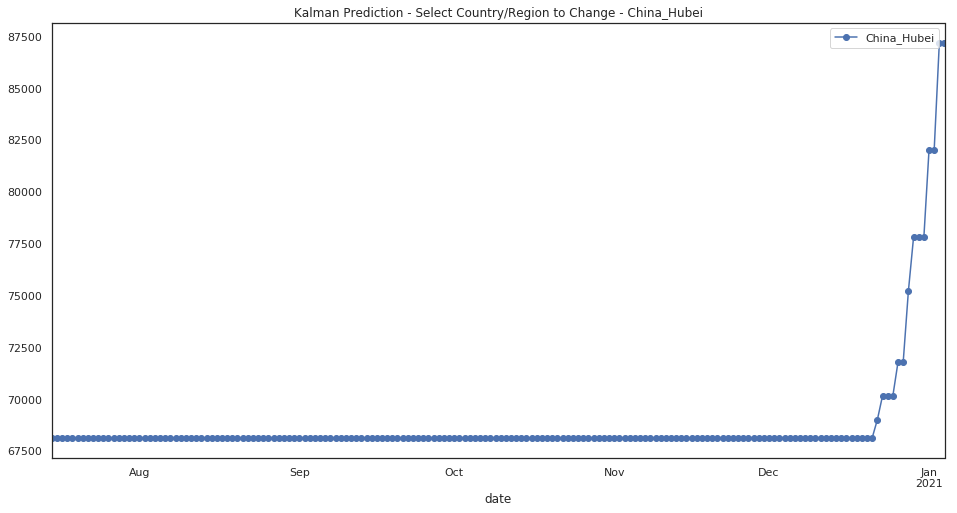

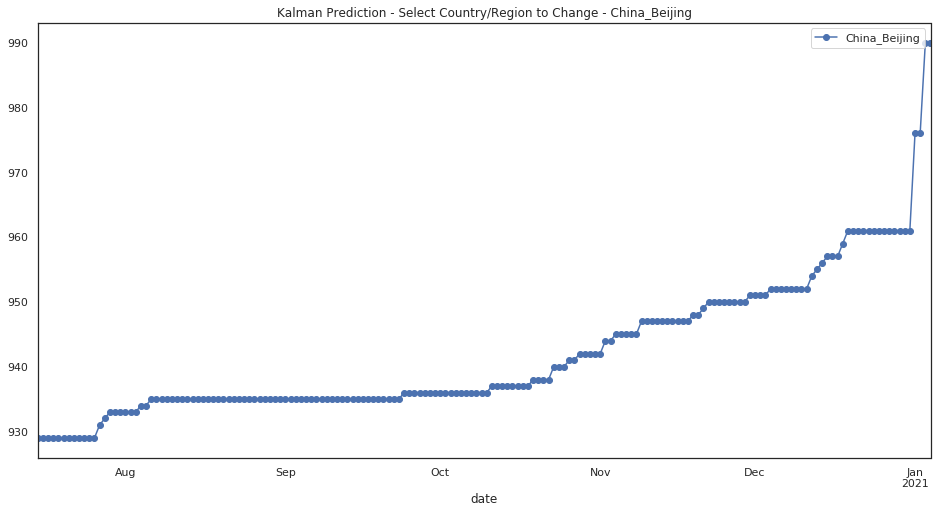

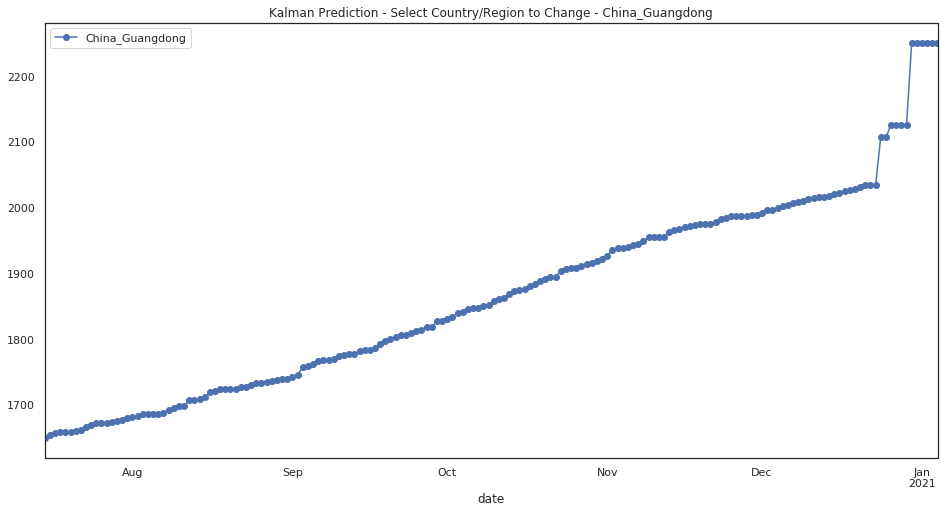

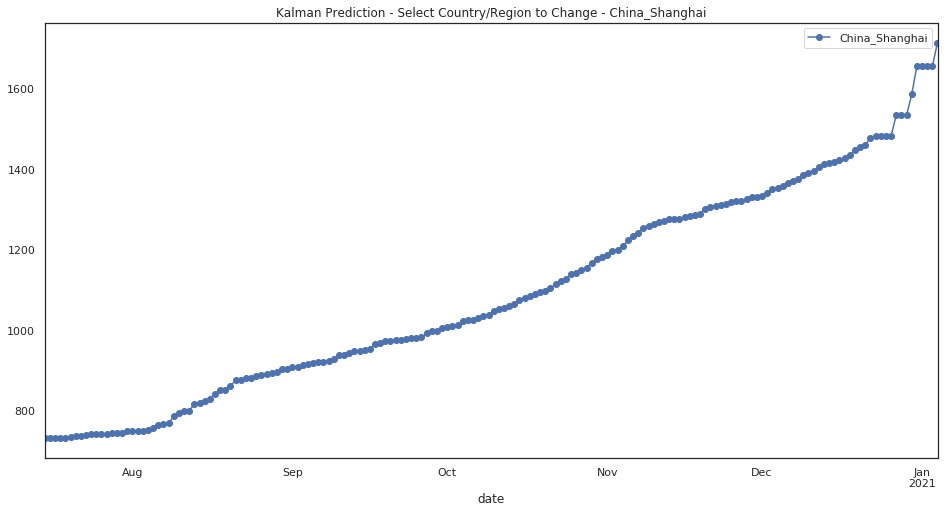

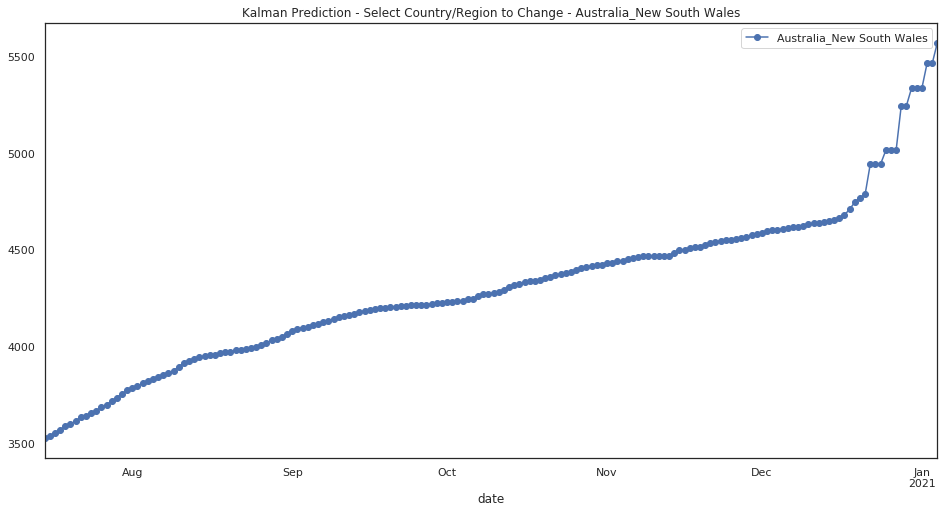

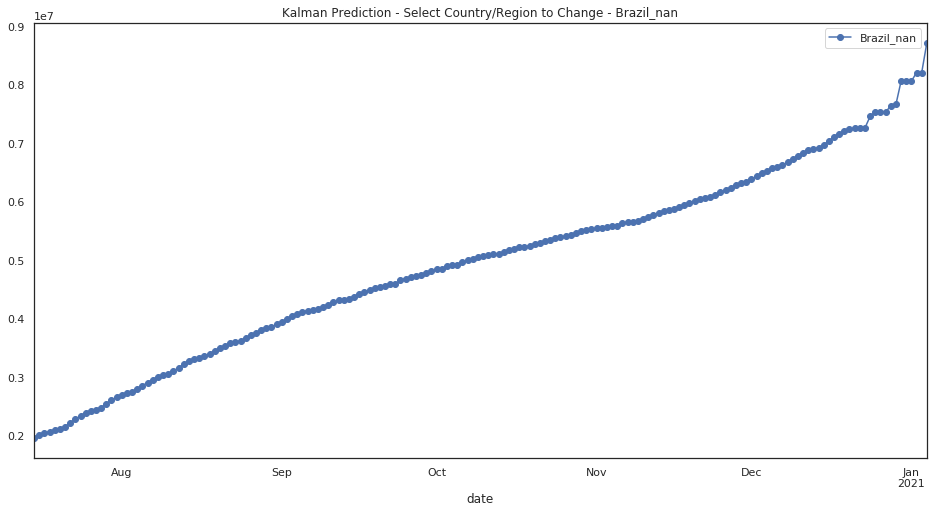

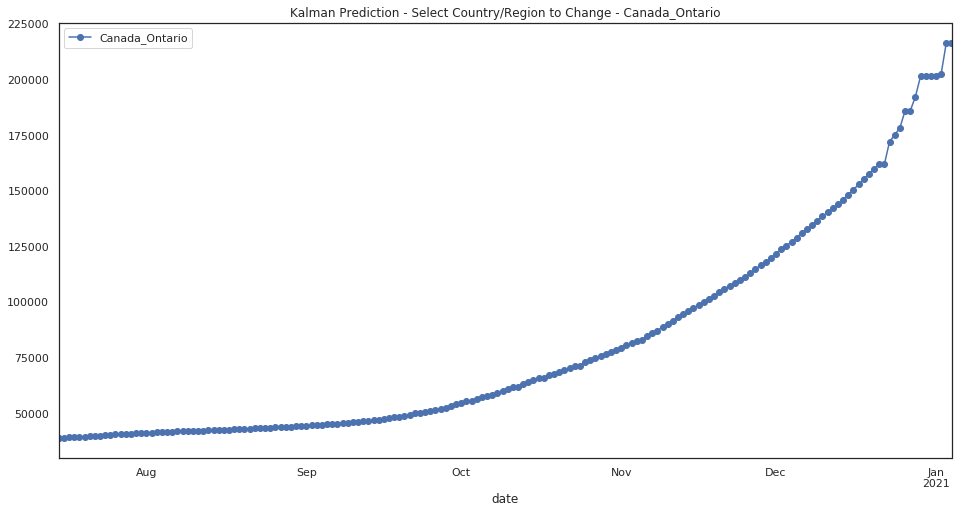

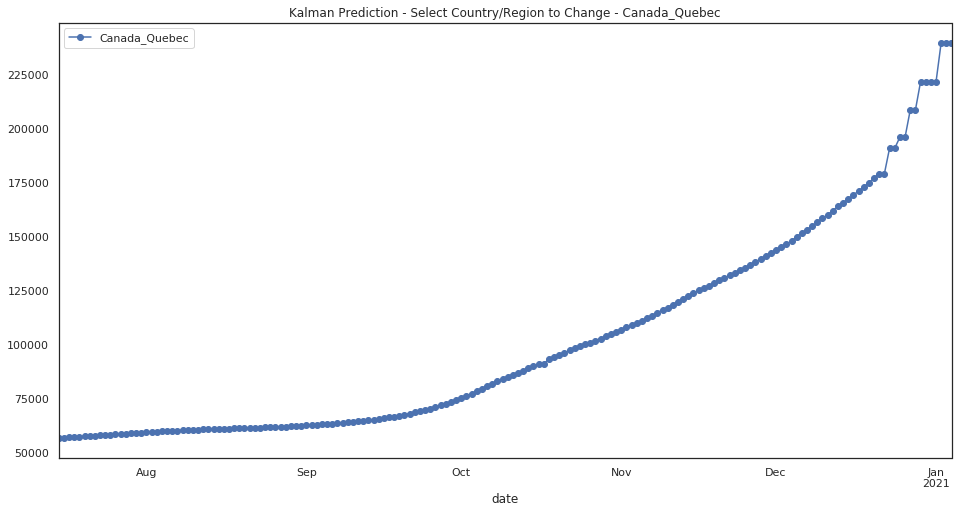

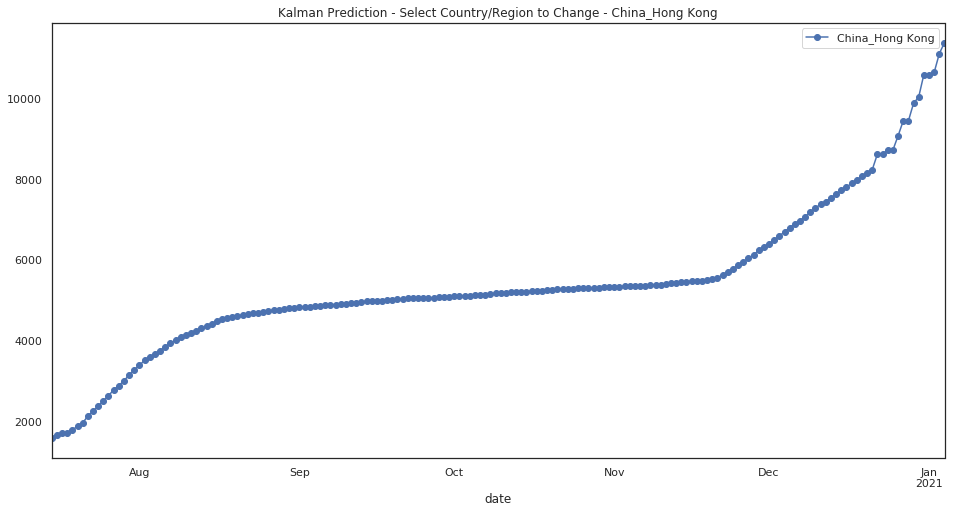

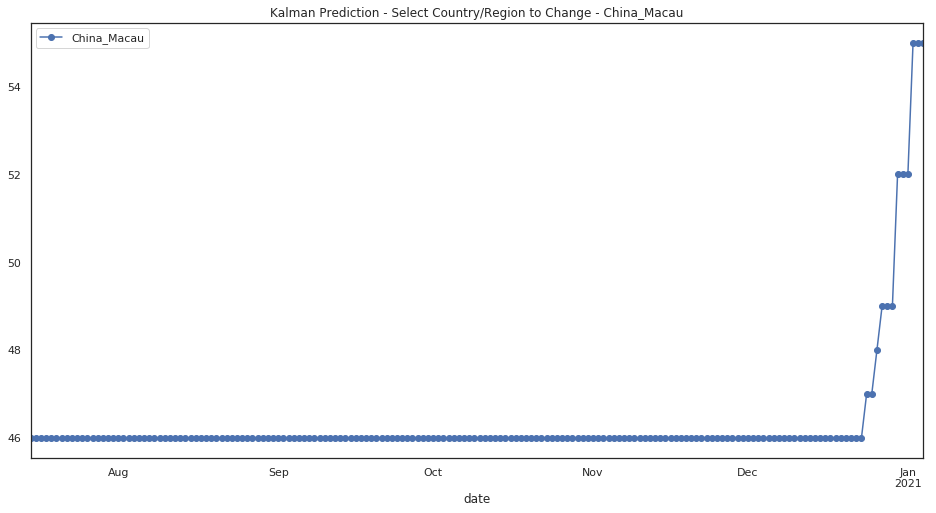

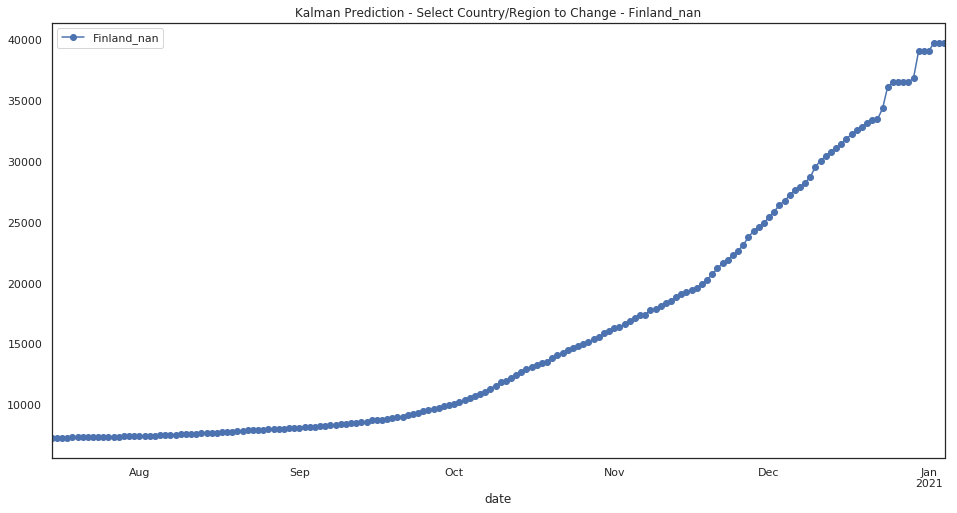

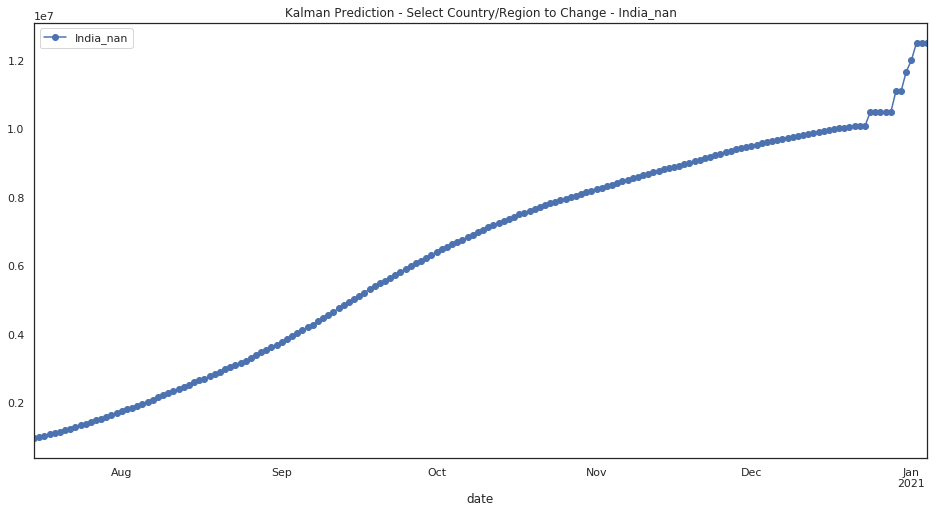

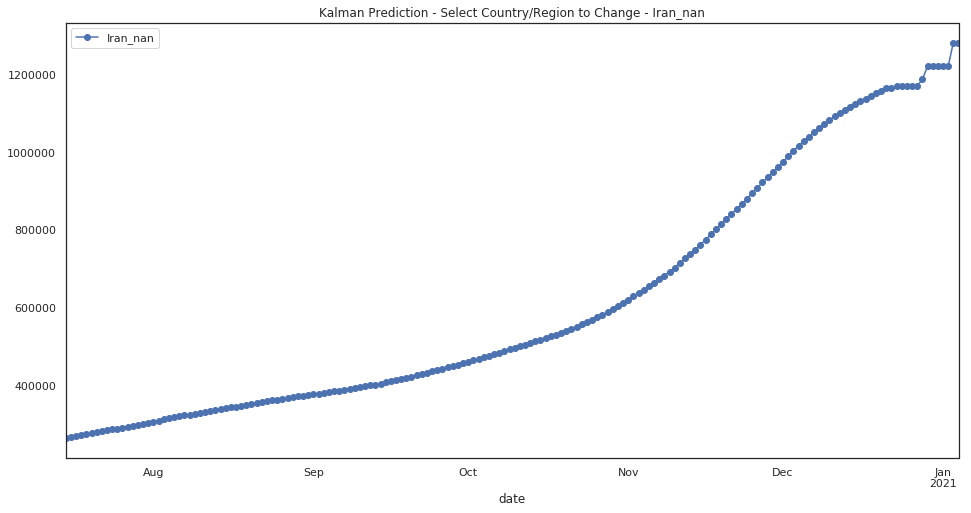

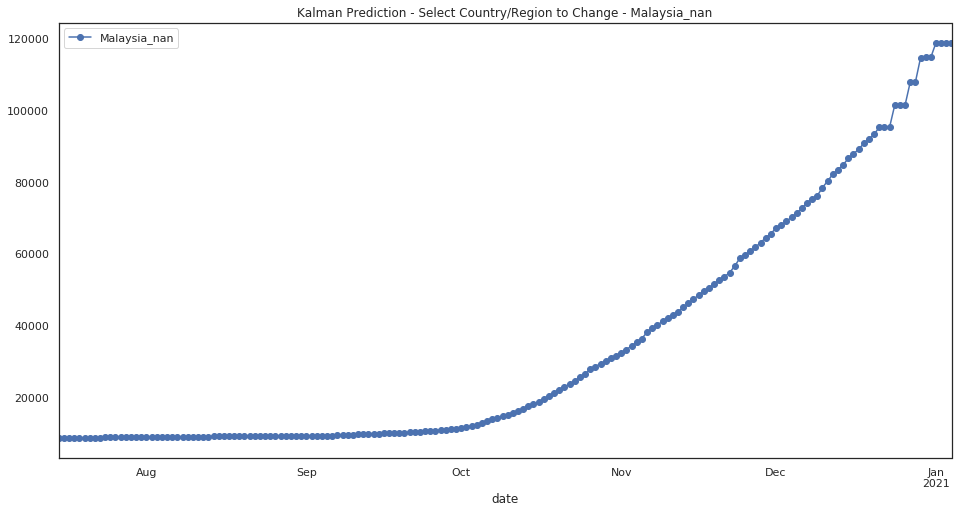

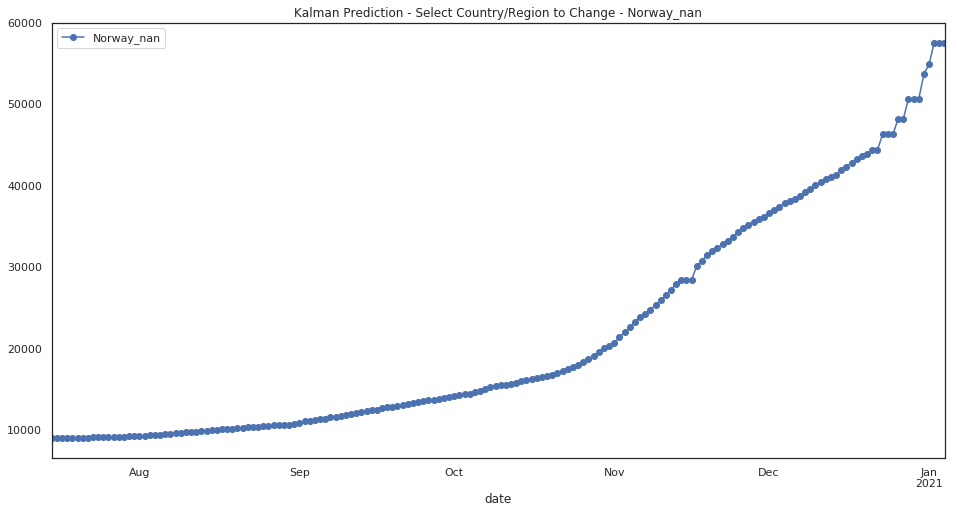

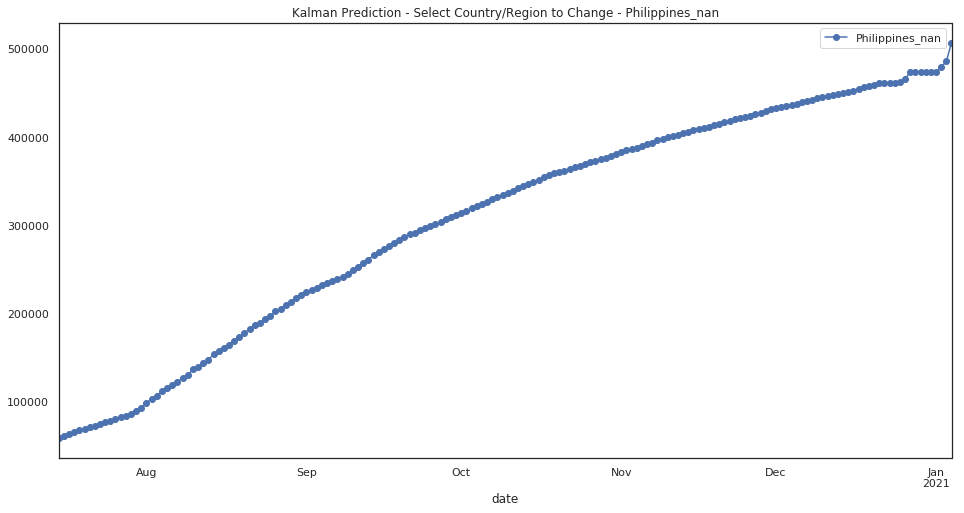

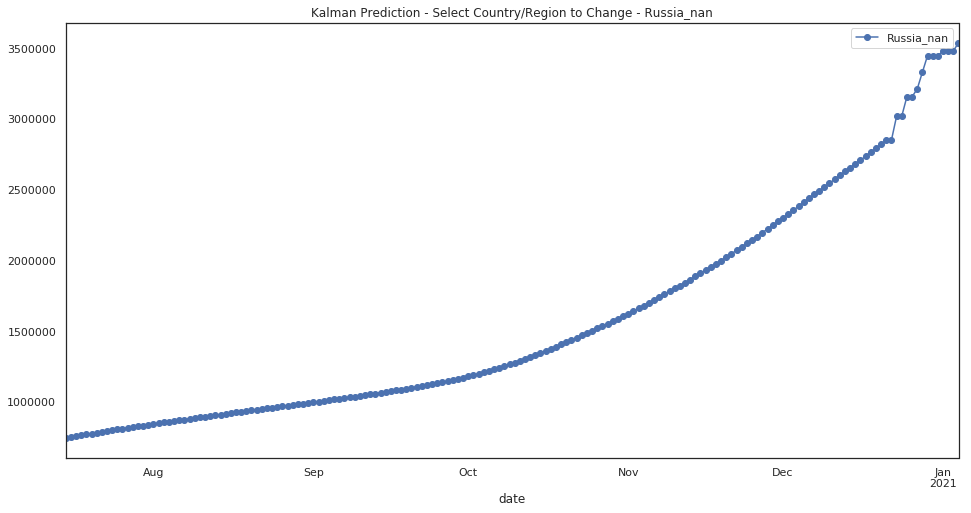

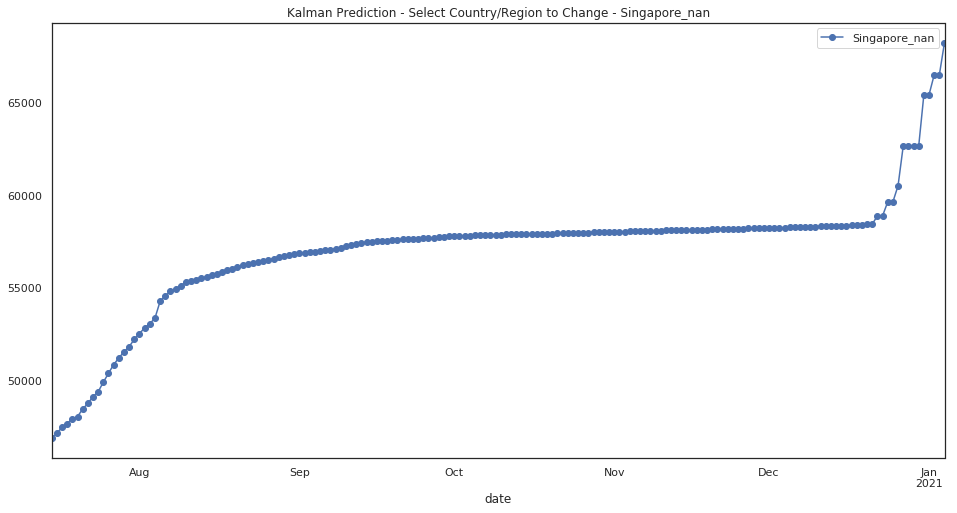

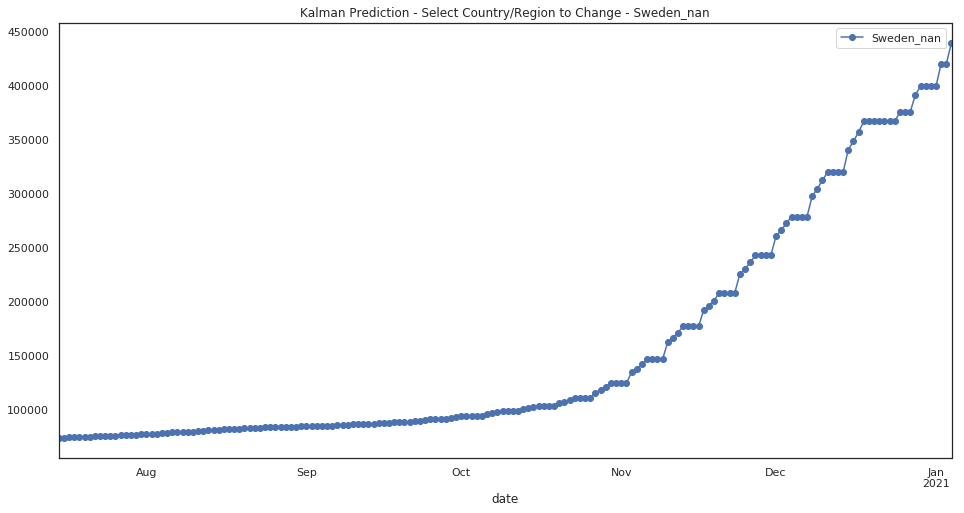

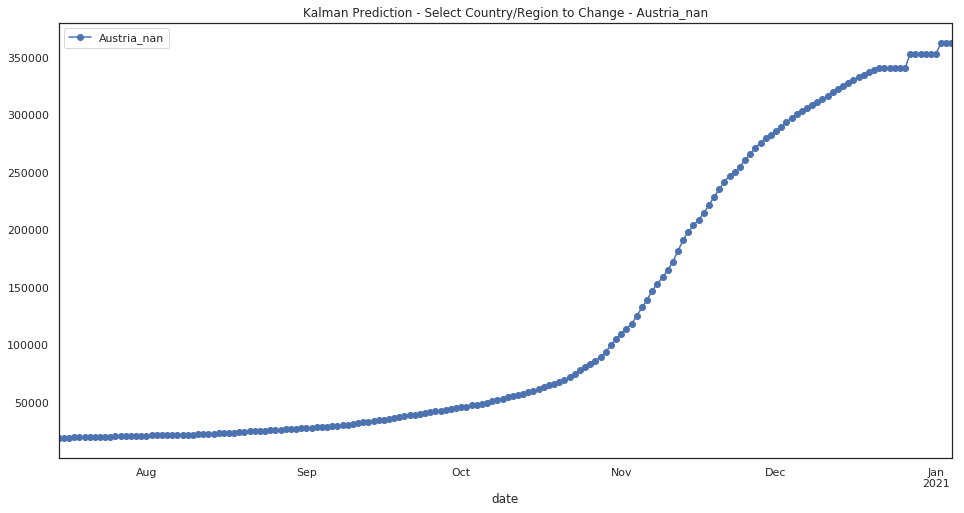

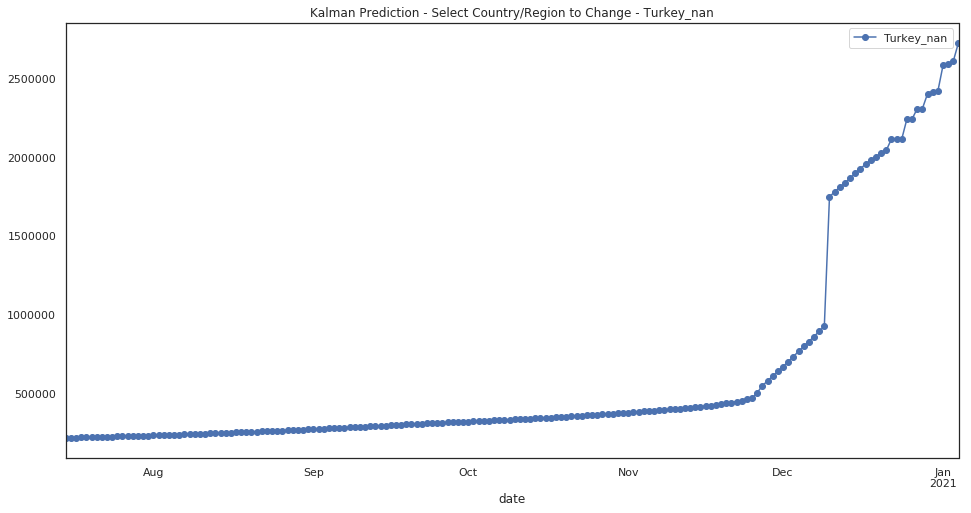

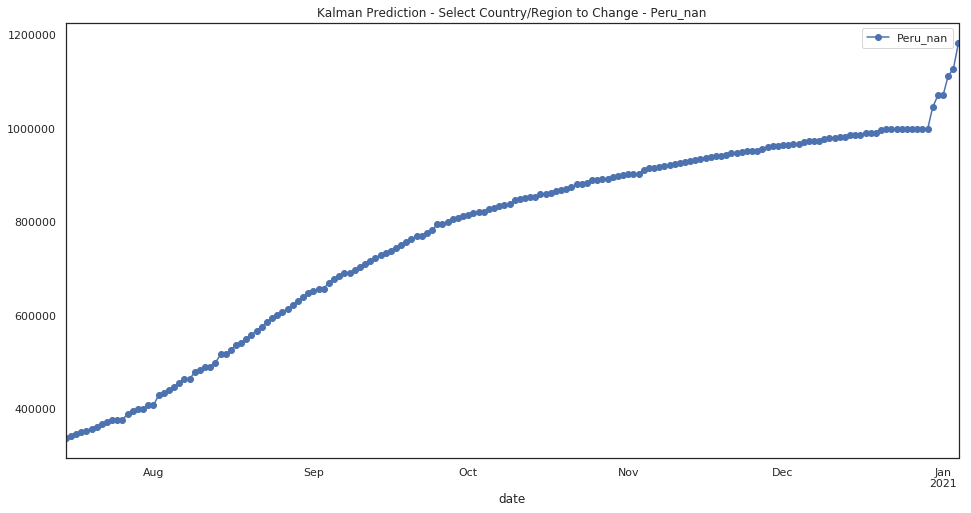

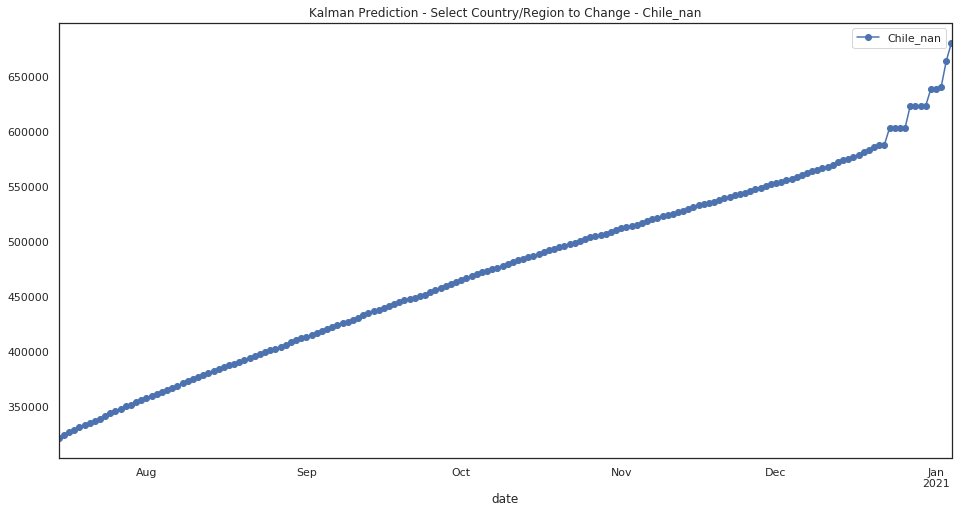

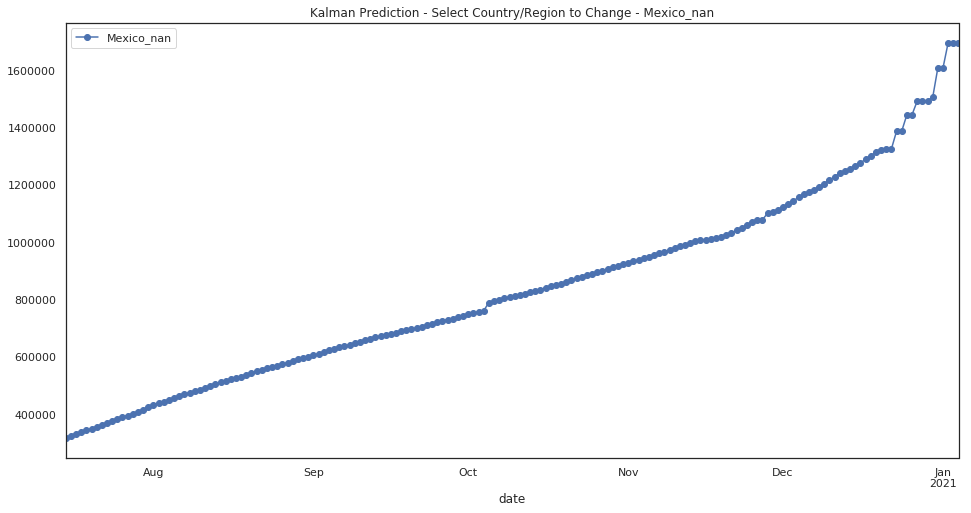

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2021-01-04 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      25498458.0
India_nan                                   NaN      12513270.0
Brazil_nan                                  NaN       8721667.0
Russia_nan                                  NaN       3540968.0
France_nan                                  NaN       2834158.0
Turkey_nan                                  NaN       2729099.0
United Kingdom_nan                          NaN       2621682.0
Spain_nan                                   NaN       2422467.0
Italy_nan                                   NaN       2374896.0
Germany_nan                                 NaN       1949669.0
Colombia_nan                                NaN       1836122.0
Argentina_nan                               NaN       1711640.0
Mexico_nan                                  NaN       1696853.0
Poland_nan                                  NaN       1432375.0
Ukraine_nan                                 NaN       1358351.0
Iran_nan                                    NaN       1282505.0
Peru_nan                                    NaN       1183406.0
South Africa_nan                            NaN       1154814.0
Indonesia_nan                               NaN        763348.0
Romania_nan                                 NaN        748352.0
Netherlands_nan                             NaN        729197.0
Belgium_nan                                 NaN        695626.0
Chile_nan                                   NaN        680751.0
Czechia_nan                                 NaN        672365.0
Iraq_nan                                    NaN        671002.0
Pakistan_nan                                NaN        567765.0
Bangladesh_nan                              NaN        534599.0
Philippines_nan                             NaN        507380.0
Morocco_nan                                 NaN        499625.0
Israel_nan                                  NaN        481479.0
...                                         ...             ...
Canada_Prince Edward Island                 NaN           130.0
Saint Vincent and the Grenadines_nan        NaN           122.0
Dominica_nan                                NaN           103.0
United Kingdom_British Virgin Islands       NaN            96.0
China_Ningxia                               NaN            87.0
Australia_Northern Territory                NaN            86.0
Canada_Yukon                                NaN            68.0
China_Macau                                 NaN            55.0
Fiji_nan                                    NaN            53.0
Laos_nan                                    NaN            44.0
France_New Caledonia                        NaN            42.0
Saint Kitts and Nevis_nan                   NaN            42.0
Denmark_Greenland                           NaN            37.0
Timor-Leste_nan                             NaN            35.0
Holy See_nan                                NaN            31.0
Canada_Northwest Territories                NaN            29.0
United Kingdom_Falkland Islands (Malvinas)  NaN            28.0
China_Qinghai                               NaN            20.0
Solomon Islands_nan                         NaN            19.0
France_Saint Pierre and Miquelon            NaN            16.0
Canada_Grand Princess                       NaN            16.0
Canada_Repatriated Travellers               NaN            15.0
United Kingdom_Montserrat                   NaN            14.0
United Kingdom_Anguilla                     NaN            10.0
MS Zaandam_nan                              NaN             9.0
Marshall Islands_nan                        NaN             4.0
Samoa_nan                                   NaN             2.0
Vanuatu_nan                                 NaN             1.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[271 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          39923.0      12828.0      27592.0      10321.0   
2020-07-16          39989.0      12914.0      28099.0      10334.0   
2020-07-17          35060.0       3851.0      21355.0        877.0   
2020-07-18          35219.0       3906.0      21948.0        880.0   
2020-07-19          35279.0       4008.0      22958.0        880.0   
2020-07-20          35453.0       4090.0      23556.0        880.0   
2020-07-21          35493.0       4171.0      24152.0        884.0   
2020-07-22          35605.0       4290.0      24749.0        884.0   
2020-07-23          35994.0       4485.0      25440.0        896.0   
2020-07-24          36092.0       4518.0      26109.0        952.0   
2020-07-25          36120.0       4598.0      26733.0        897.0   
2020-07-26          36225.0       4787.0      27328.0        957.0   
2020-07-27          36343.0       4803.0      27937.0        966.0   
2020-07-28          36445.0       4944.0      28574.0        907.0   
2020-07-29          36555.0       5068.0      29197.0        979.0   
2020-07-30          36628.0       5176.0      29801.0        918.0   
2020-07-31          36752.0       5279.0      30370.0        950.0   
2020-08-01          36809.0       5407.0      30925.0        962.0   
2020-08-02          36792.0       5469.0      31444.0        985.0   
2020-08-03          36820.0       5578.0      31946.0        992.0   
2020-08-04          36860.0       5744.0      32478.0        937.0   
2020-08-05          36910.0       5844.0      33036.0        984.0   
2020-08-06          37020.0       5966.0      33616.0       1007.0   
2020-08-07          37116.0       6125.0      34163.0        957.0   
2020-08-08          37163.0       6243.0      34697.0        955.0   
2020-08-09          37192.0       6390.0      35176.0       1021.0   
2020-08-10          37249.0       6505.0      35702.0       1024.0   
2020-08-11          37354.0       6657.0      36216.0        963.0   
2020-08-12          37442.0       6785.0      36700.0       1032.0   
2020-08-13          37522.0       6939.0      37197.0        977.0   
...                     ...          ...          ...          ...   
2020-12-07          47611.0      43642.0      88846.0       7050.0   
2020-12-08          47819.0      44338.0      89388.0       7084.0   
2020-12-09          47961.0      45102.0      90006.0       7127.0   
2020-12-10          48135.0      45949.0      90593.0       7162.0   
2020-12-11          48227.0      46797.0      91147.0       7190.0   
2020-12-12          48284.0      47653.0      91676.0       7236.0   
2020-12-13          48577.0      48480.0      92152.0       7288.0   
2020-12-14          48831.0      49134.0      92639.0       7338.0   
2020-12-15          49044.0      49883.0      93125.0       7382.0   
2020-12-16          49274.0      50571.0      93567.0       7382.0   
2020-12-17          49472.0      51291.0      93996.0       7446.0   
2020-12-18          49714.0      51953.0      94433.0       7466.0   
2020-12-19          49793.0      52442.0      94857.0       7519.0   
2020-12-20          49865.0      52918.0      95274.0       7560.0   
2020-12-21          50078.0      53324.0      95732.0       7577.0   
2020-12-22          50116.0      56225.0      96275.0       7602.0   
2020-12-23          50078.0      57457.0      96379.0       7825.0   
2020-12-24          50083.0      56711.0      98425.0       8010.0   
2020-12-25          50622.0      56711.0      99672.0       8254.0   
2020-12-26          51447.0      59996.0      98771.0       8254.0   
2020-12-27          51548.0      63713.0     100599.0       8254.0   
2020-12-28          51981.0      63541.0     101479.0       8697.0   
2020-12-29          53239.0      63117.0     103824.0       8697.0   
2020-12-30          53481.0      63117.0     105594.0       8697.0   
2020-12-31

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Russia_nan',
 'France_nan',
 'Turkey_nan',
 'United Kingdom_nan',
 'Spain_nan',
 'Italy_nan',
 'Germany_nan',
 'Colombia_nan',
 'Argentina_nan',
 'Mexico_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Iran_nan',
 'Peru_nan',
 'South Africa_nan',
 'Indonesia_nan',
 'Romania_nan',
 'Netherlands_nan',
 'Belgium_nan',
 'Chile_nan',
 'Czechia_nan',
 'Iraq_nan',
 'Pakistan_nan',
 'Bangladesh_nan',
 'Philippines_nan',
 'Morocco_nan',
 'Israel_nan',
 'Serbia_nan',
 'Portugal_nan',
 'Sweden_nan',
 'Switzerland_nan',
 'Hungary_nan',
 'Saudi Arabia_nan',
 'Jordan_nan',
 'Austria_nan',
 'Japan_nan',
 'Nepal_nan',
 'Croatia_nan',
 'Ecuador_nan',
 'Azerbaijan_nan',
 'Georgia_nan',
 'Canada_Quebec',
 'Bulgaria_nan',
 'Panama_nan',
 'Belarus_nan',
 'Dominican Republic_nan',
 'United Arab Emirates_nan',
 'Canada_Ontario',
 'Kazakhstan_nan',
 'Kuwait_nan',
 'Denmark_nan',
 'Slovakia_nan',
 'Costa Rica_nan',
 'Greece_nan',
 'Lebanon_nan',
 'Armenia_nan',
 'Gua

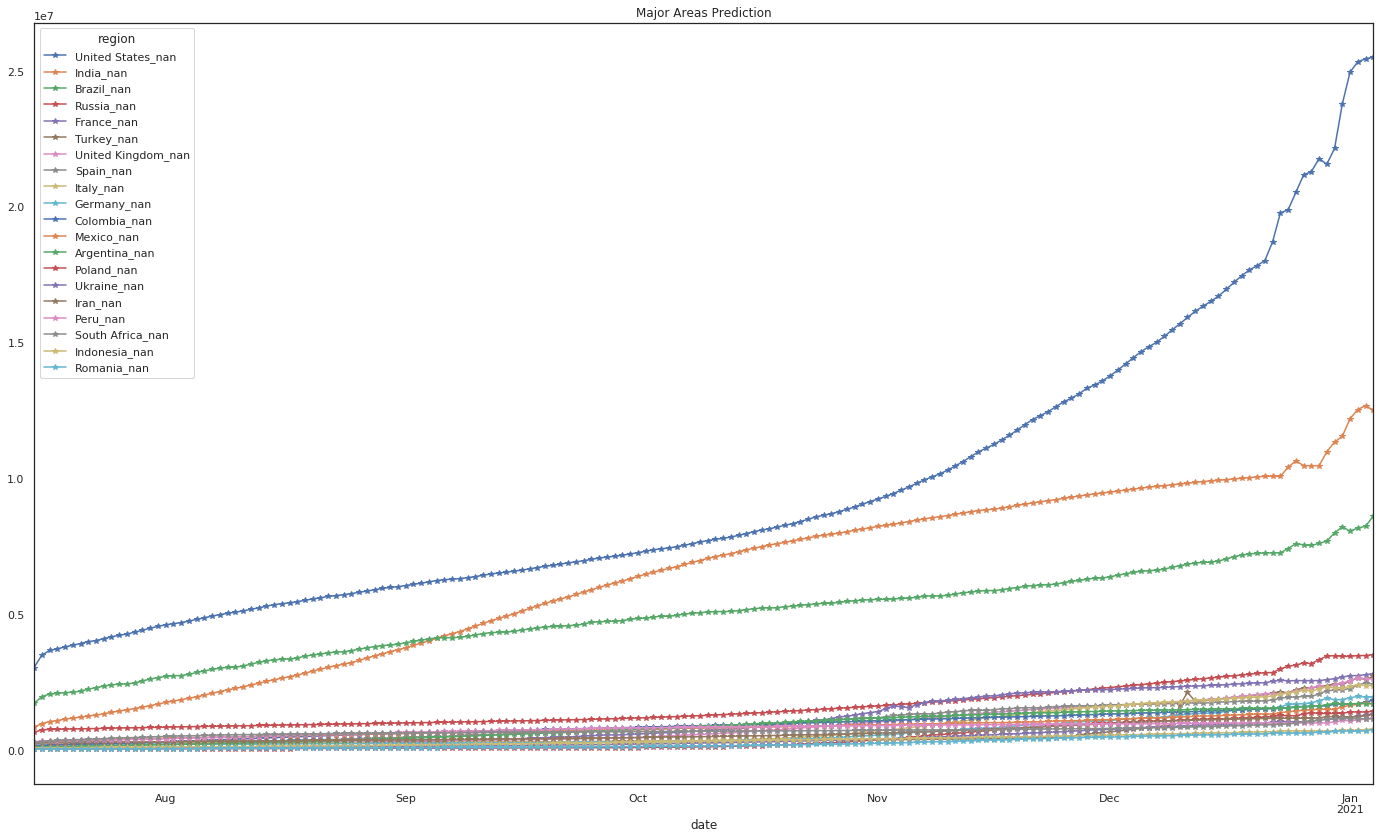

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

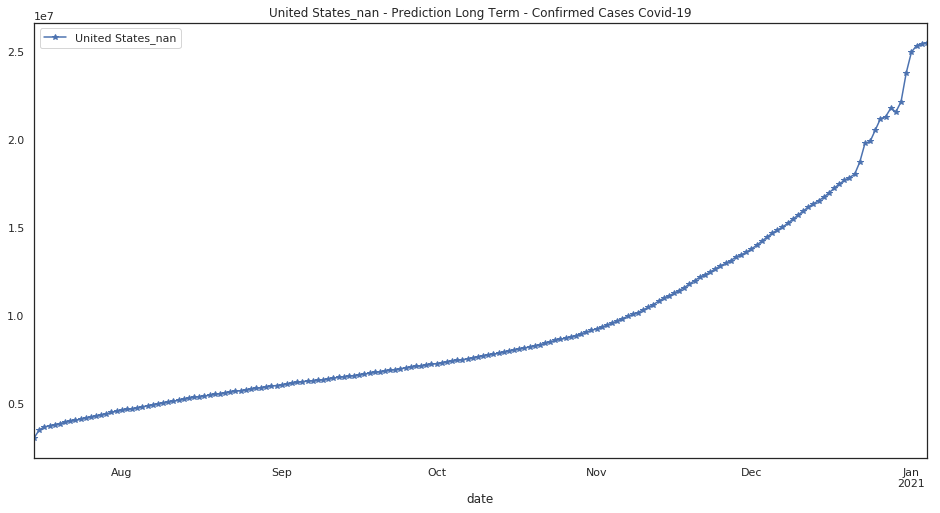

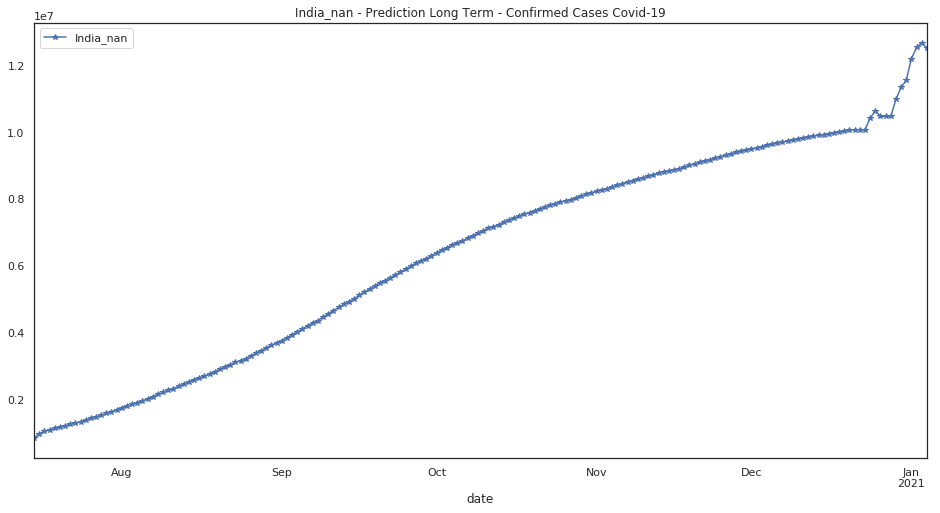

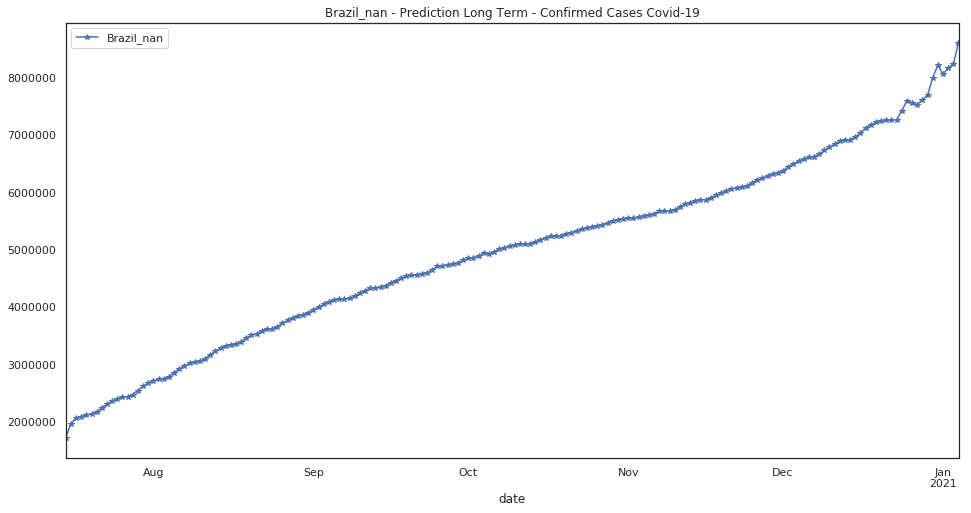

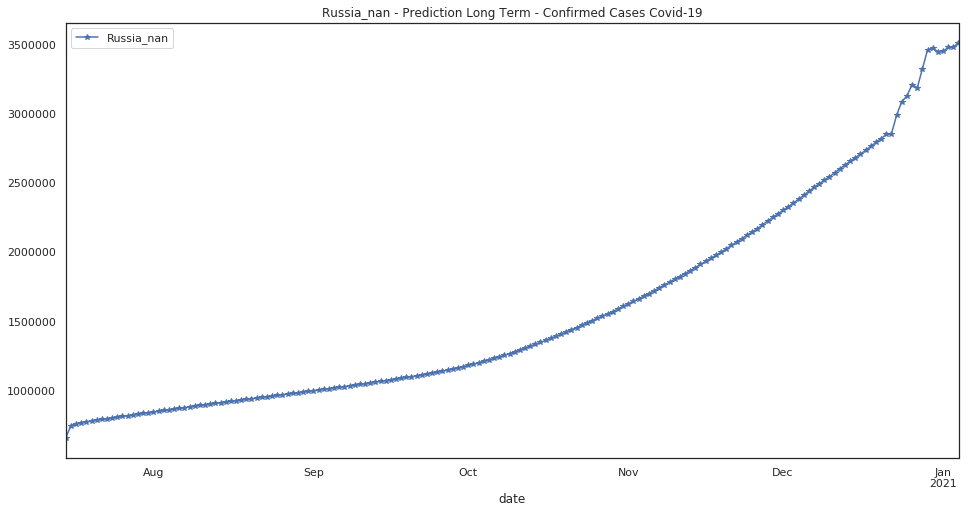

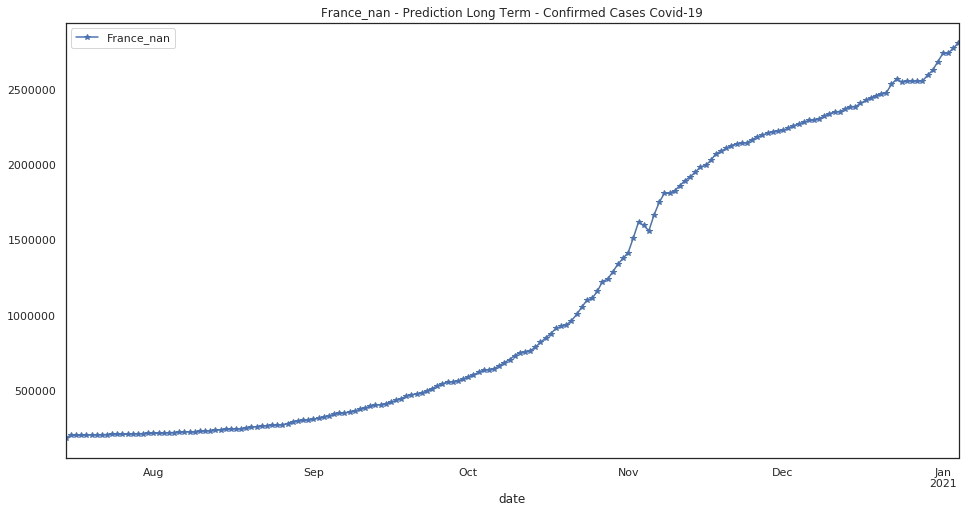

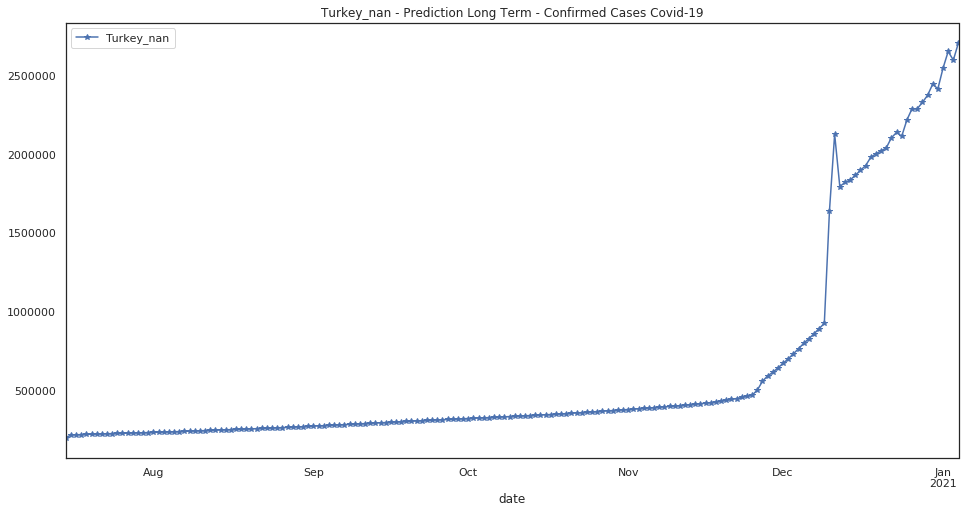

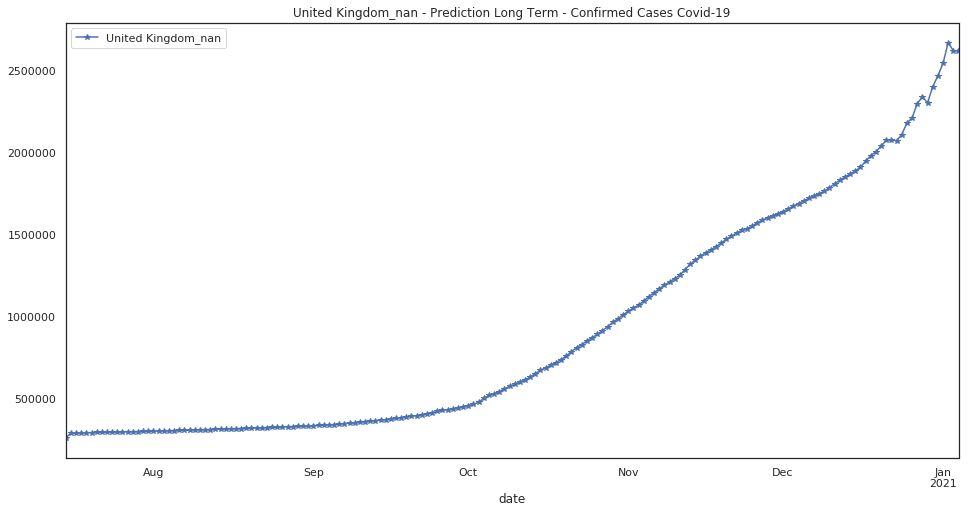

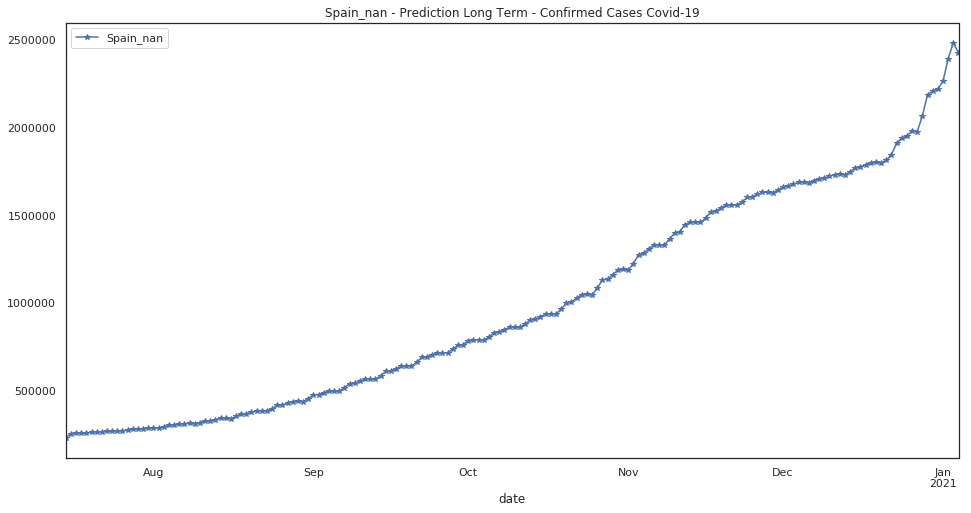

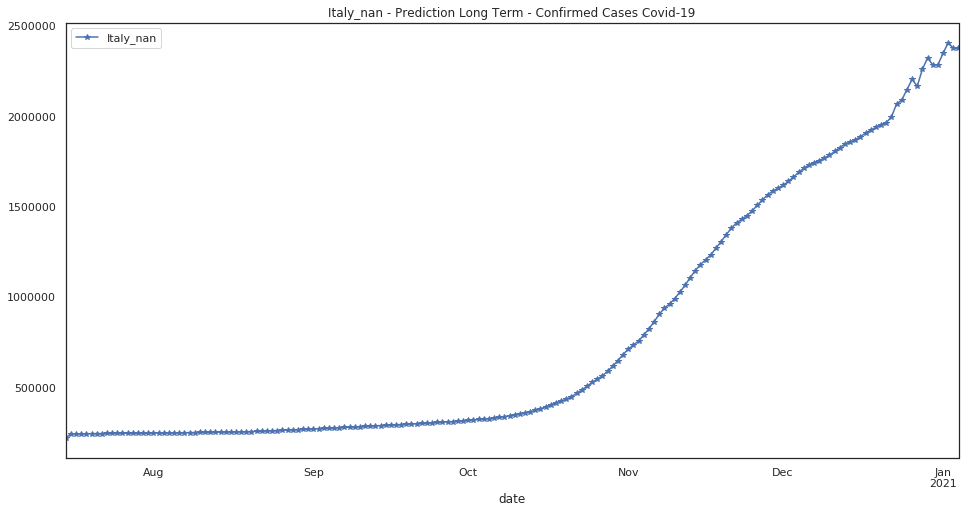

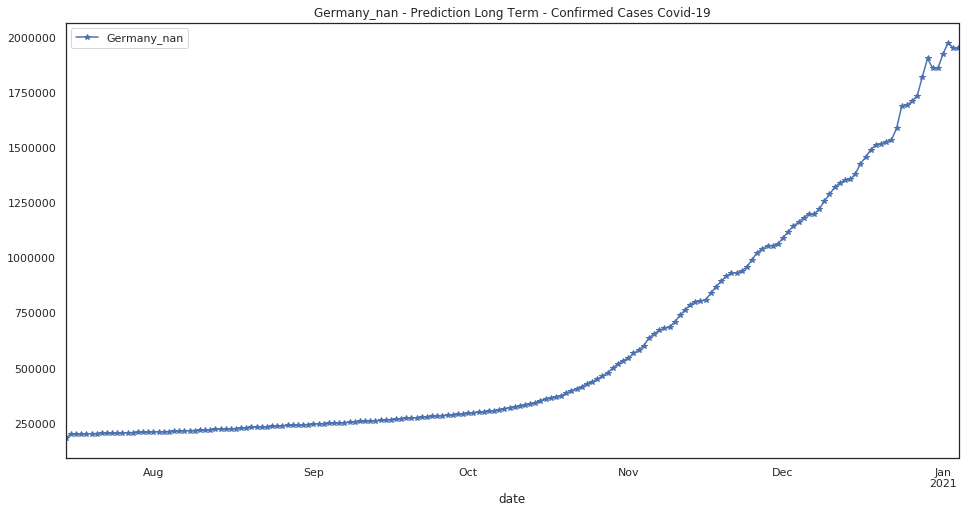

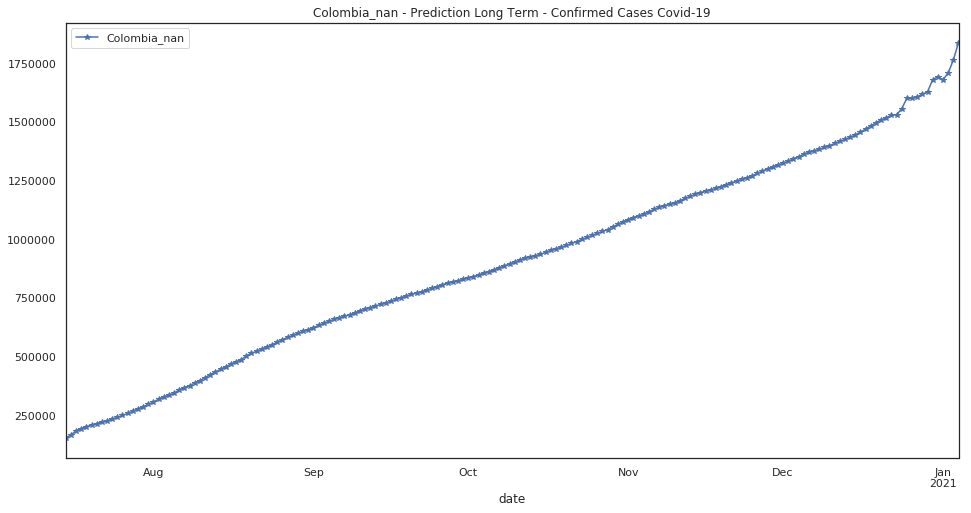

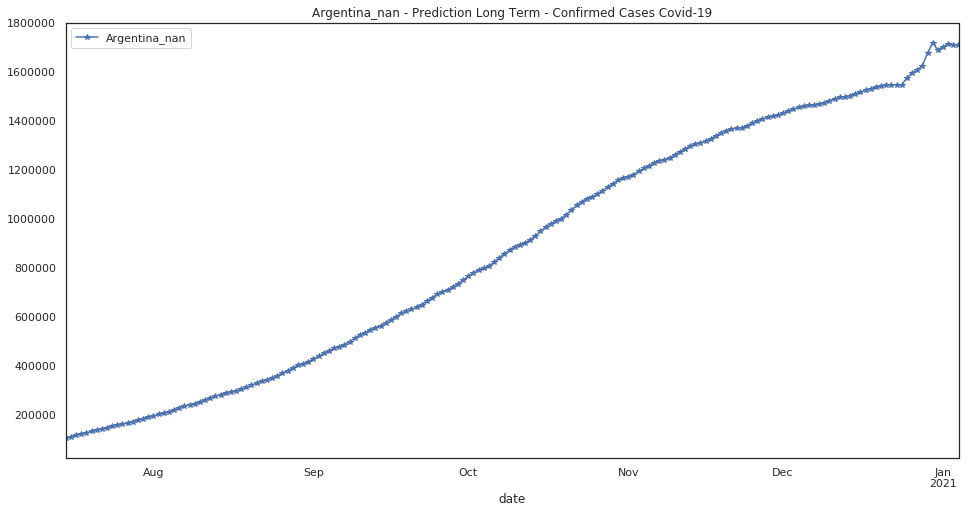

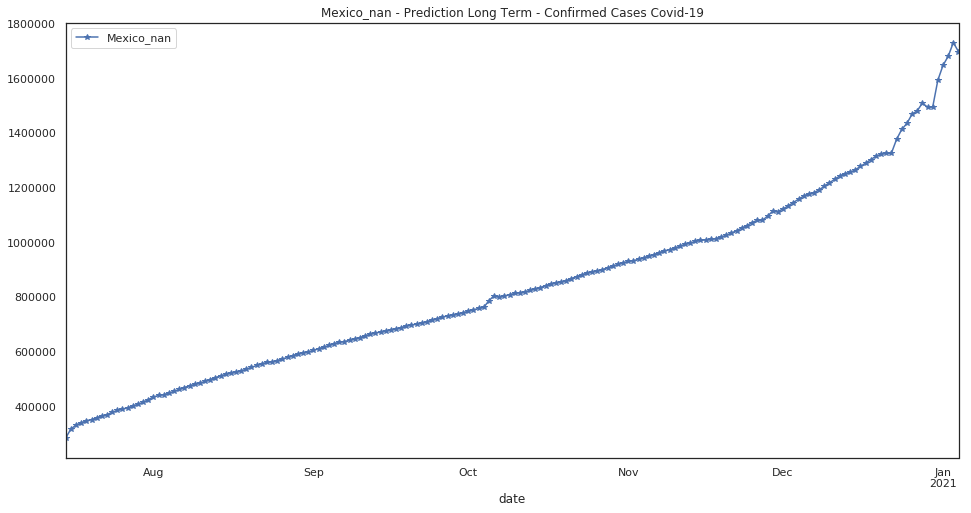

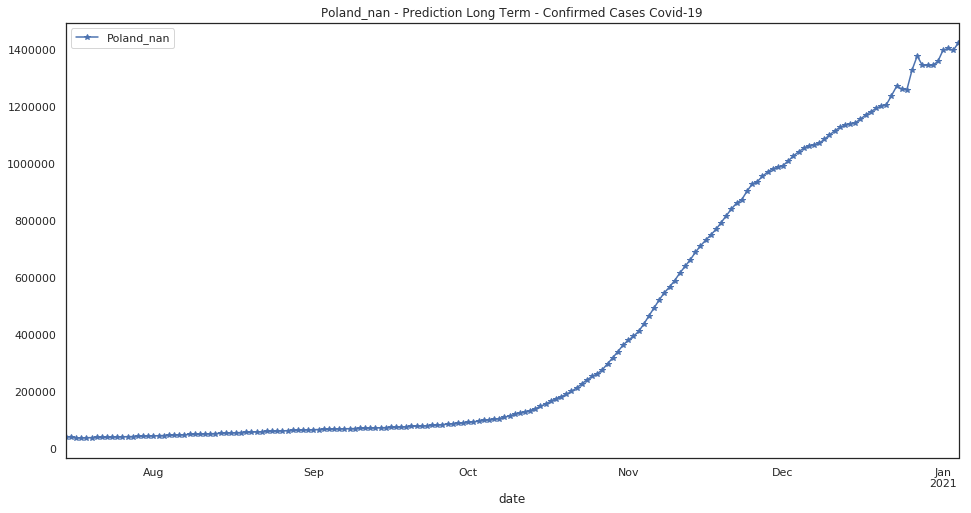

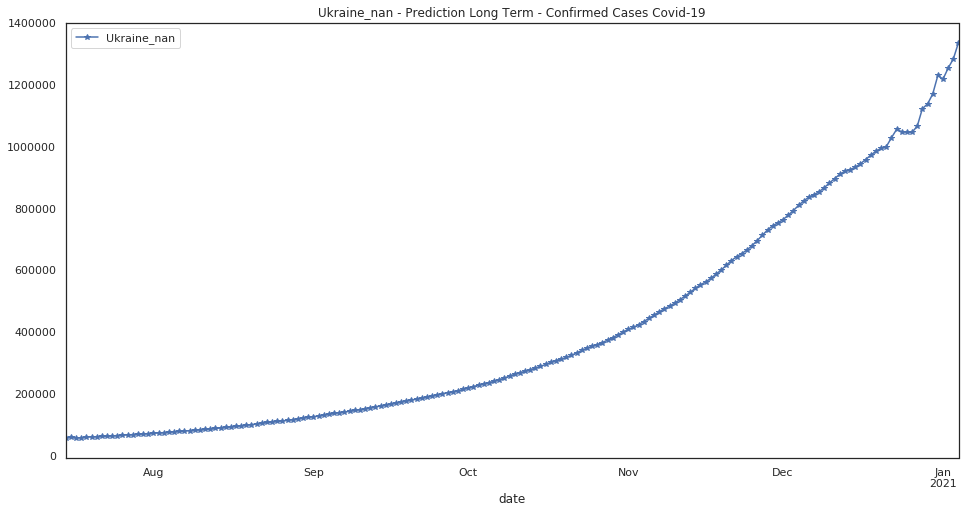

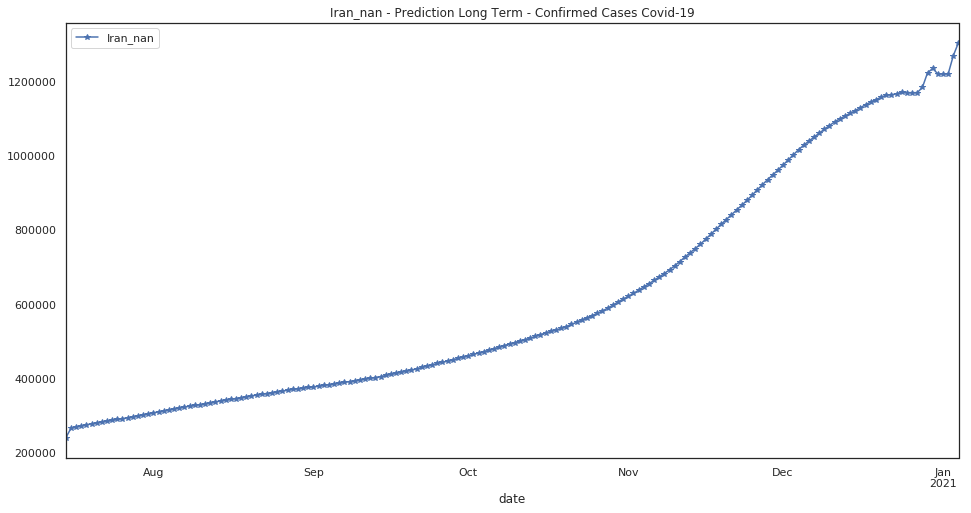

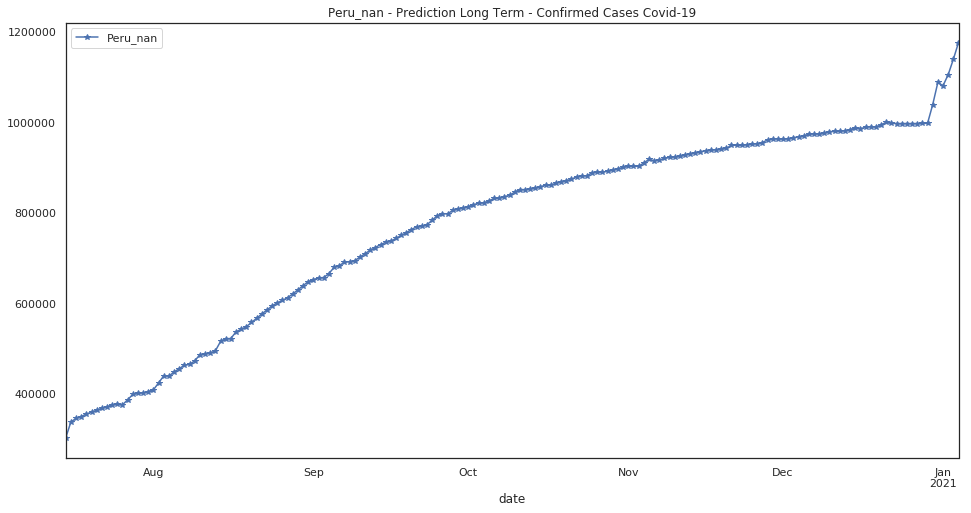

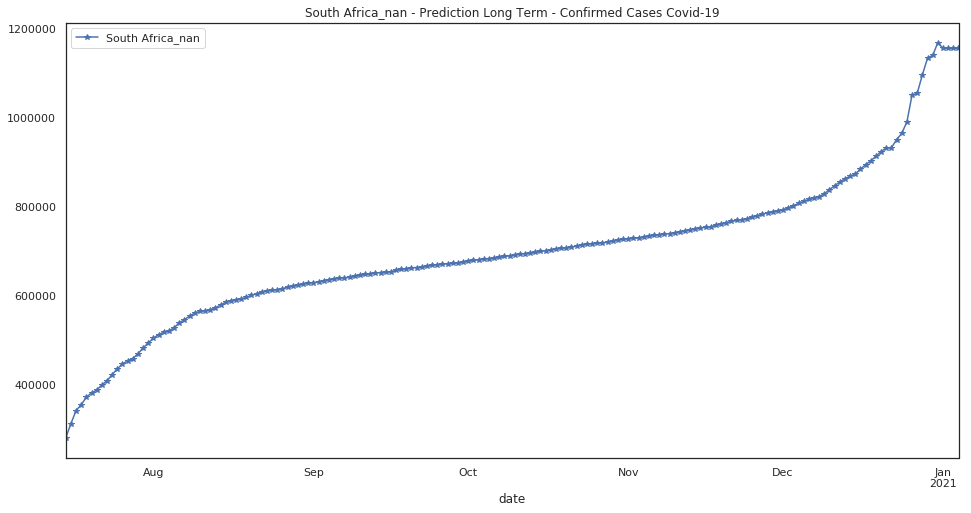

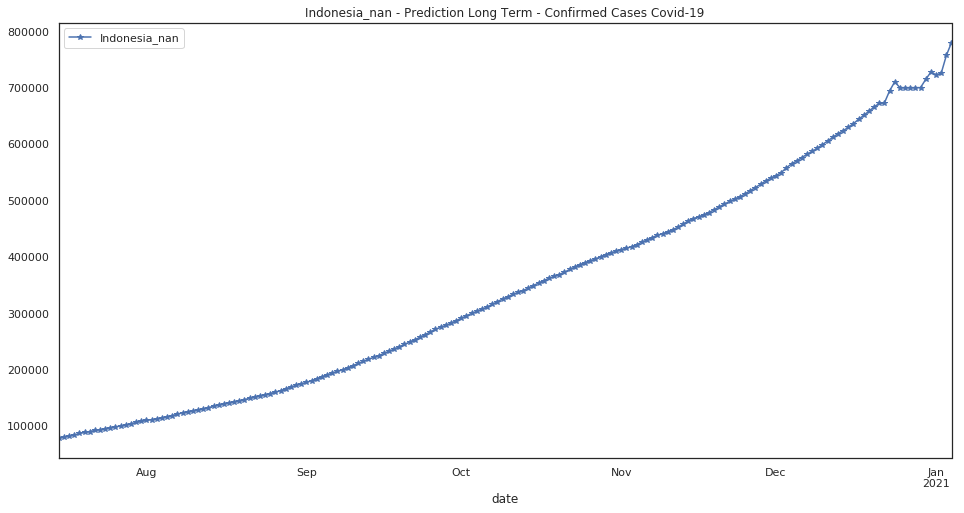

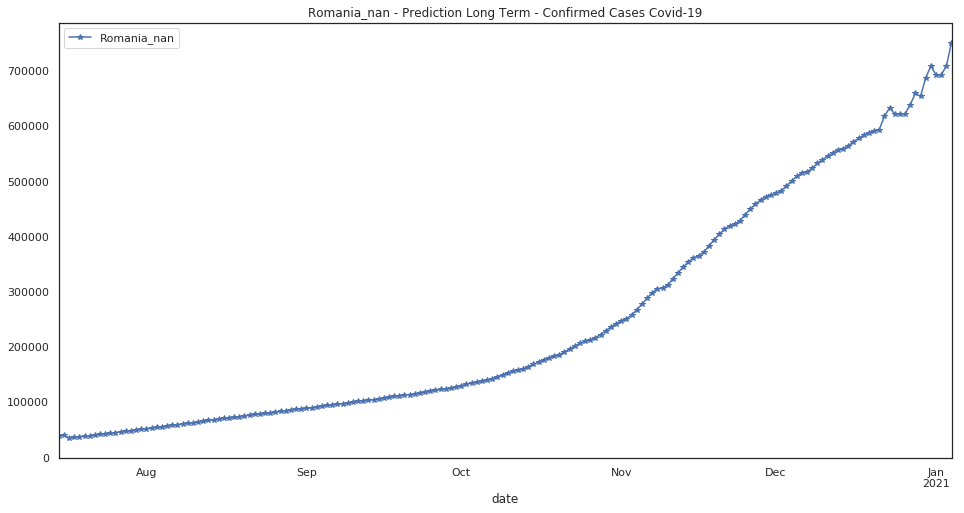

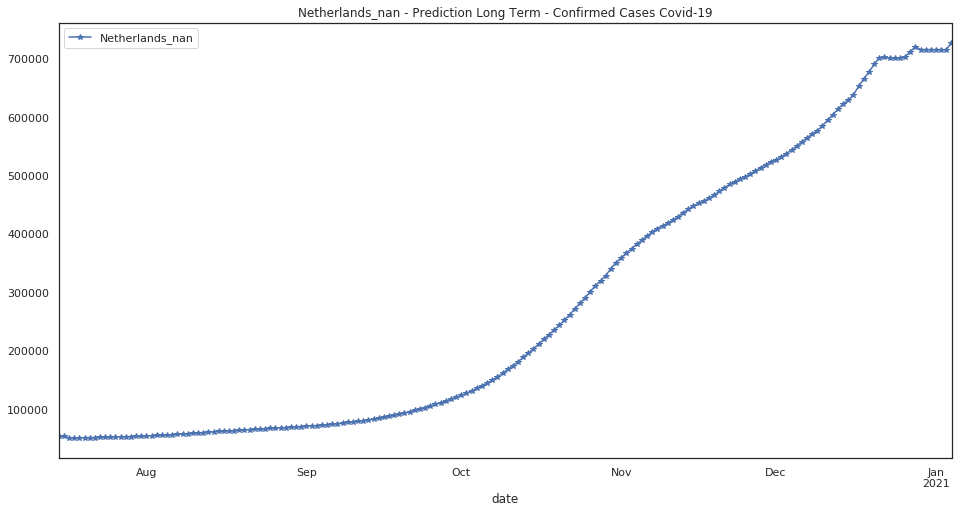

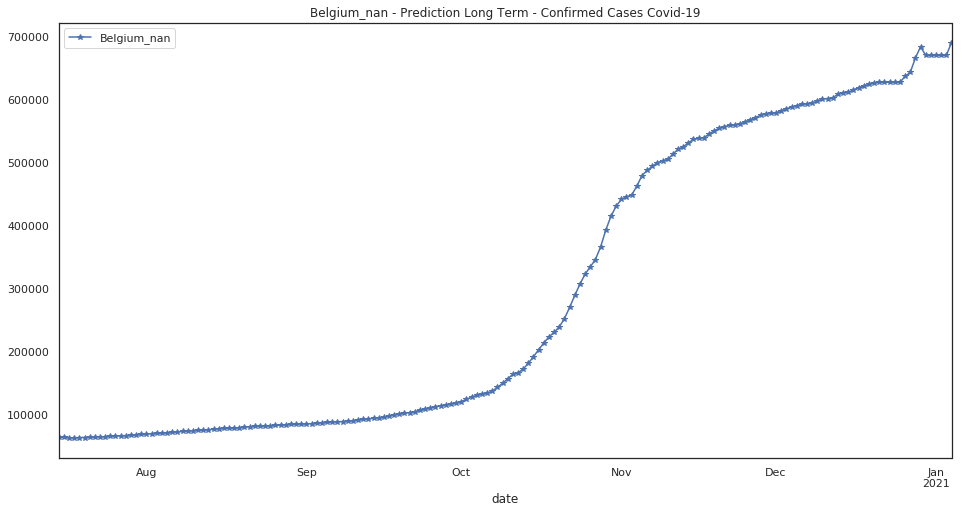

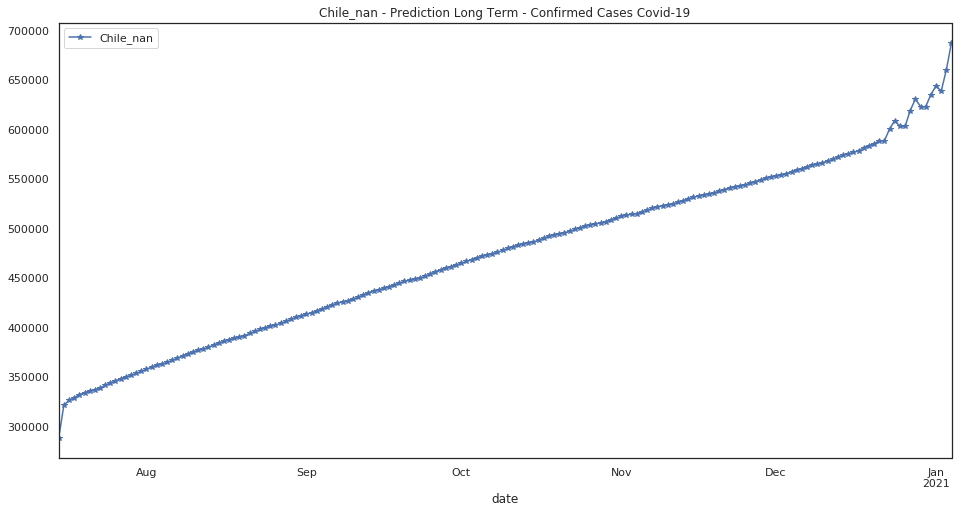

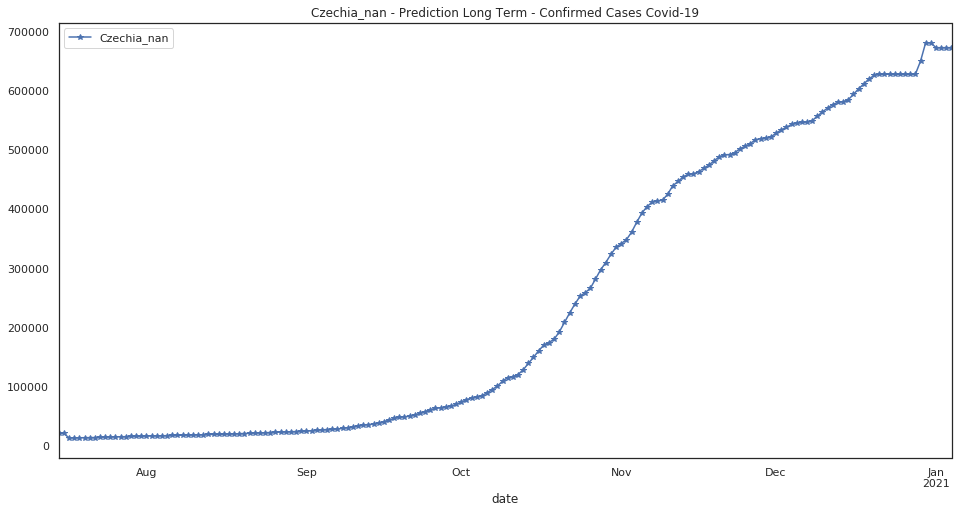

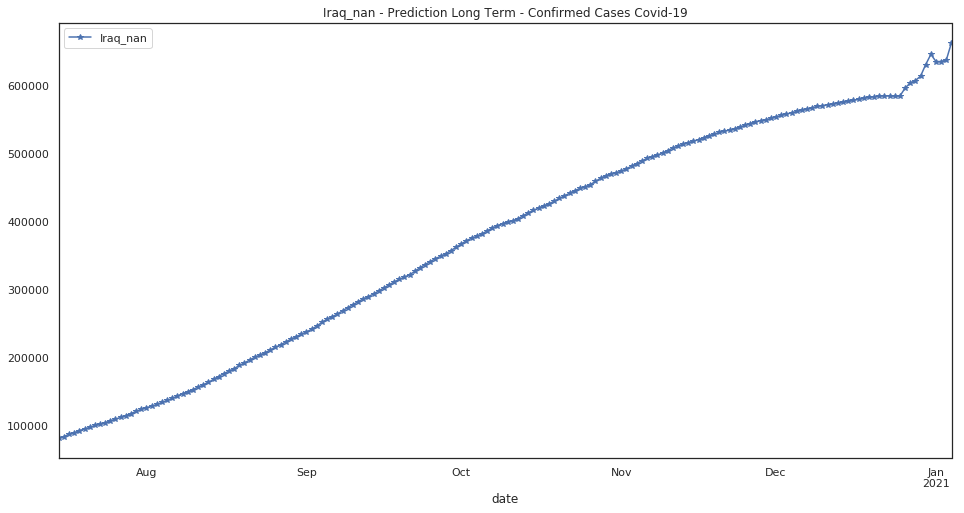

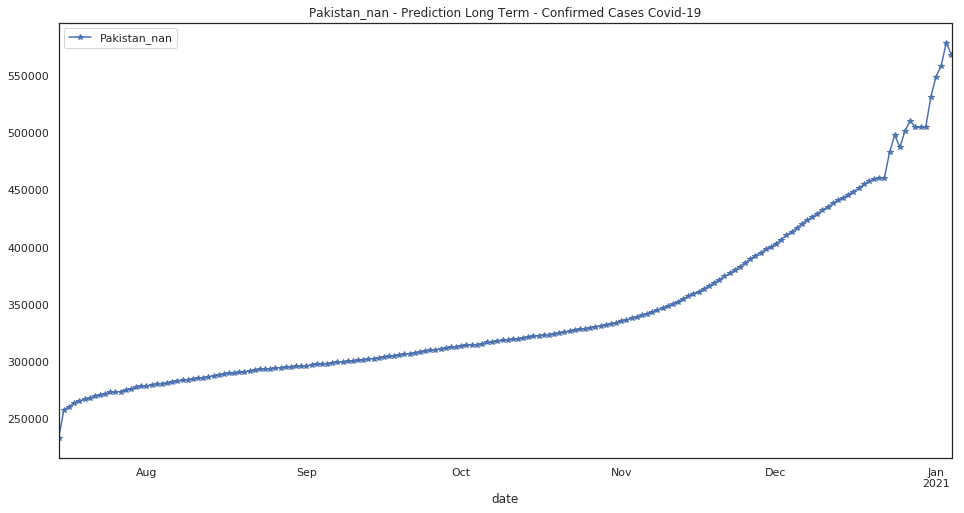

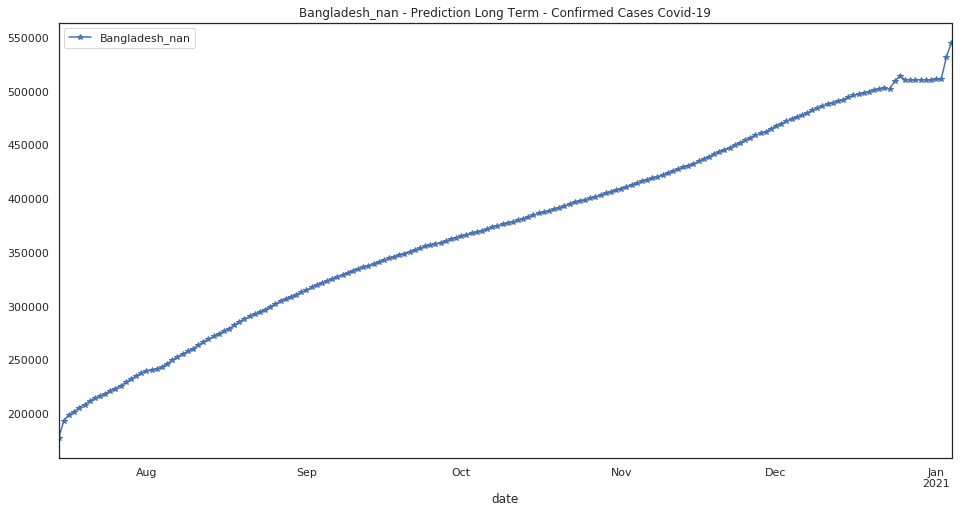

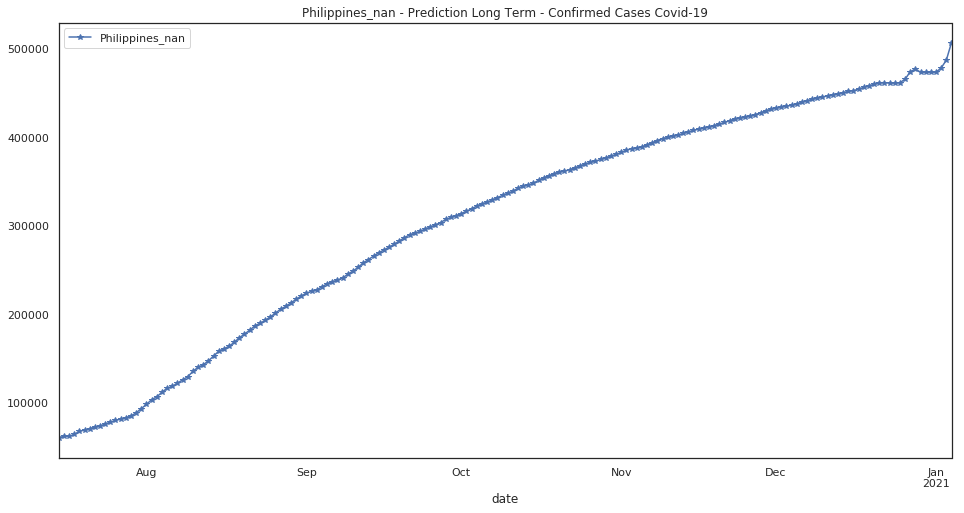

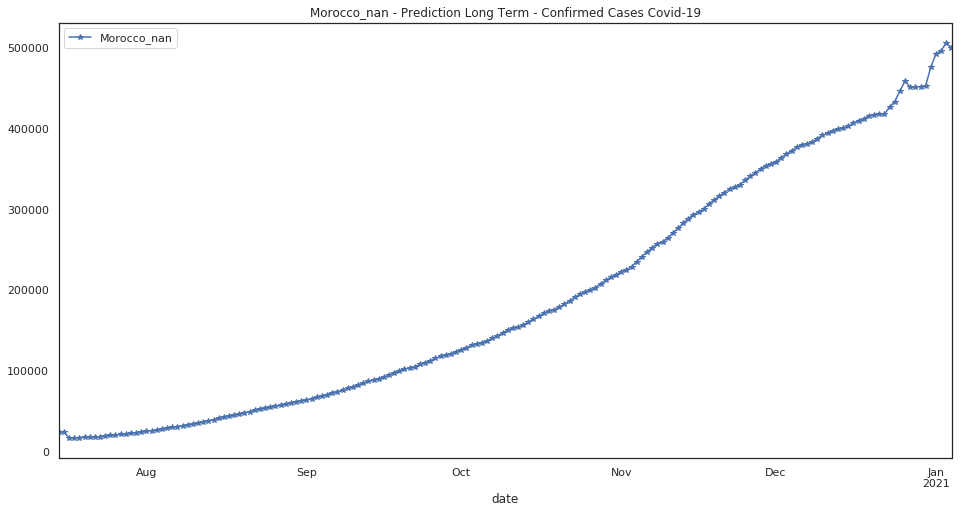

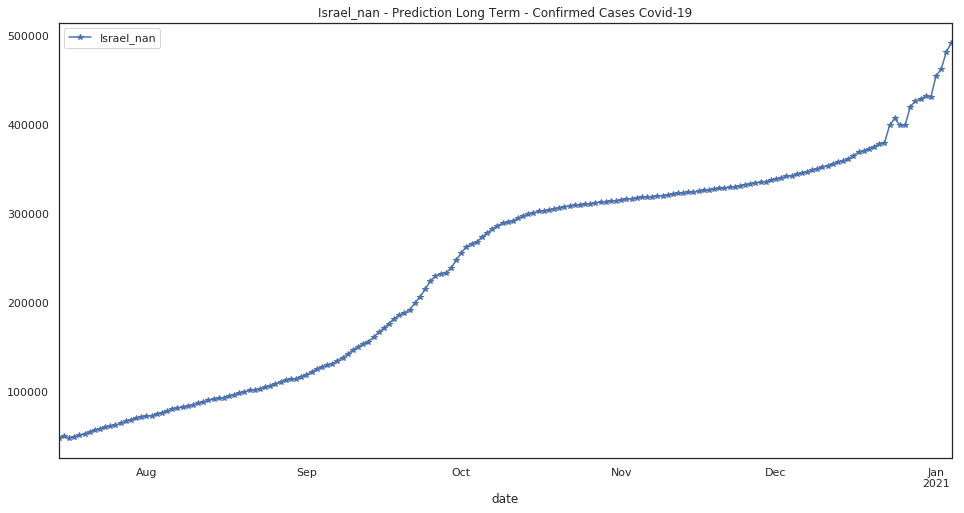

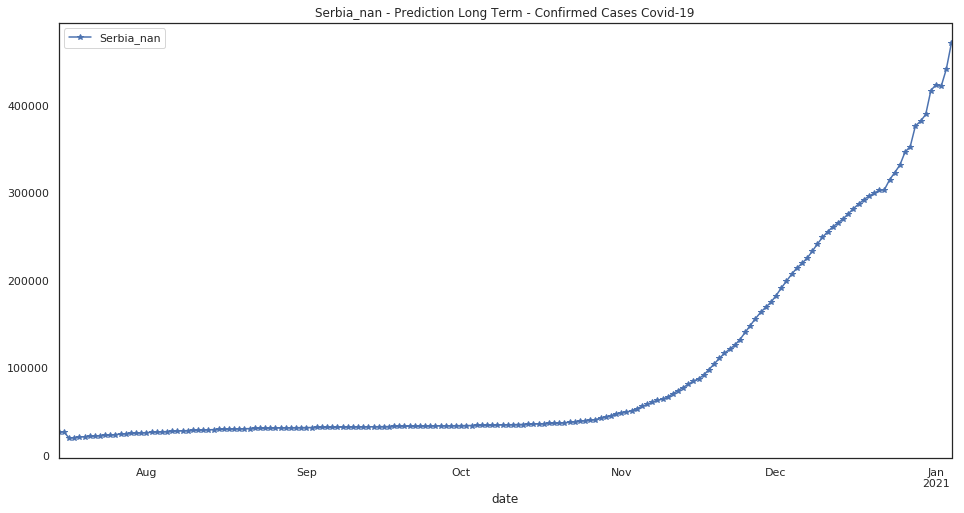

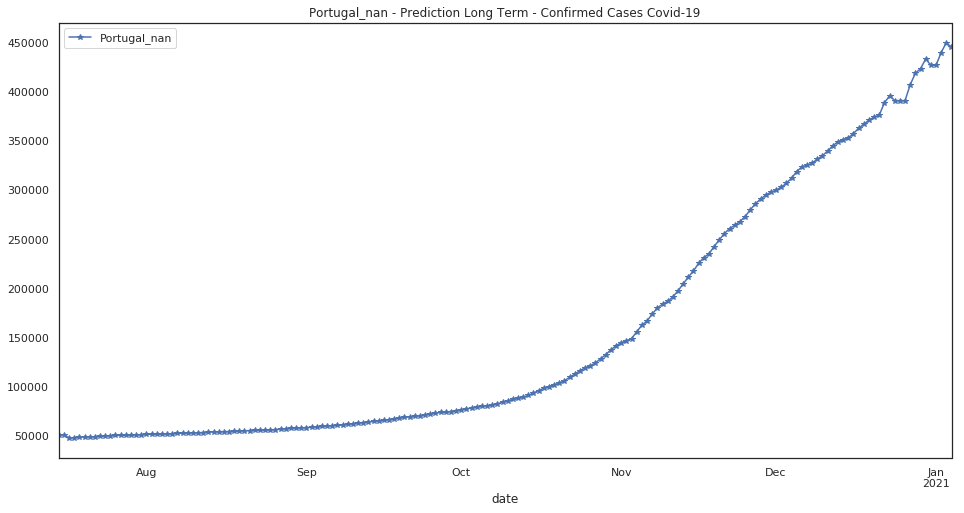

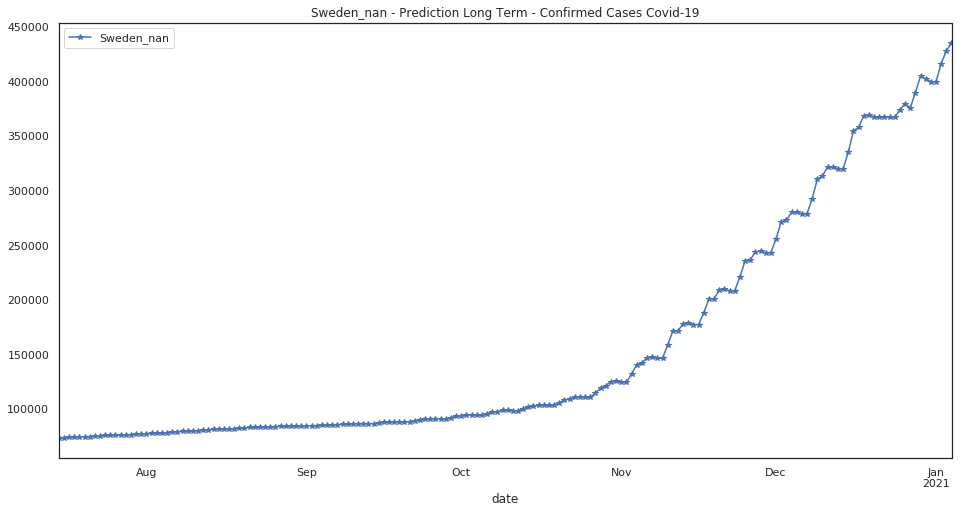

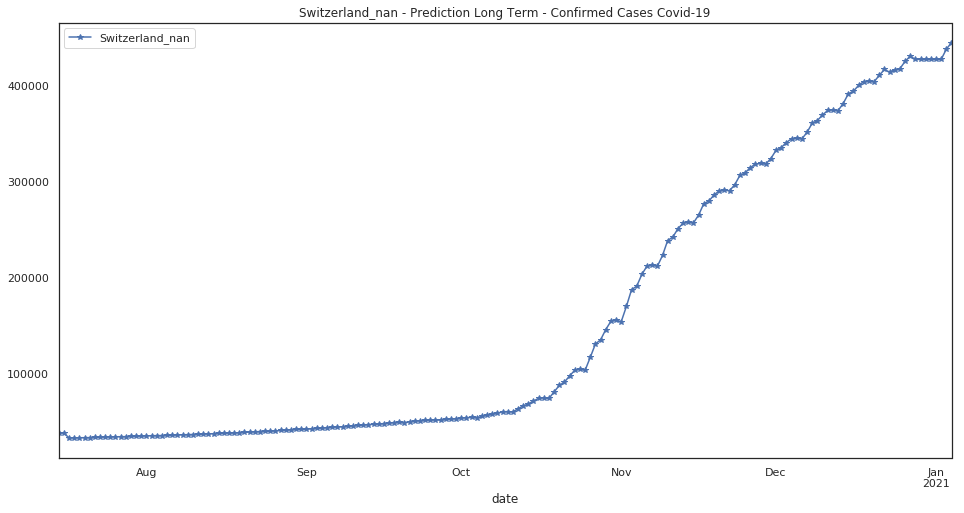

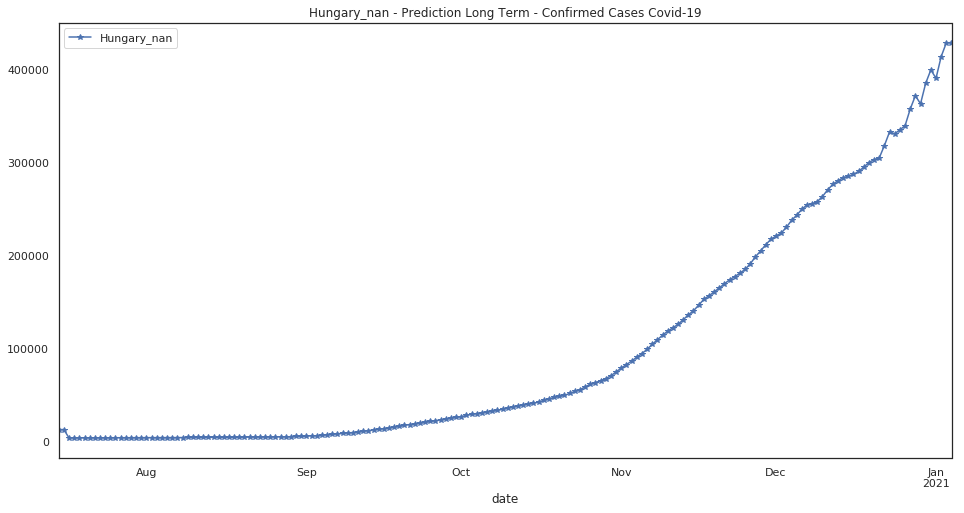

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

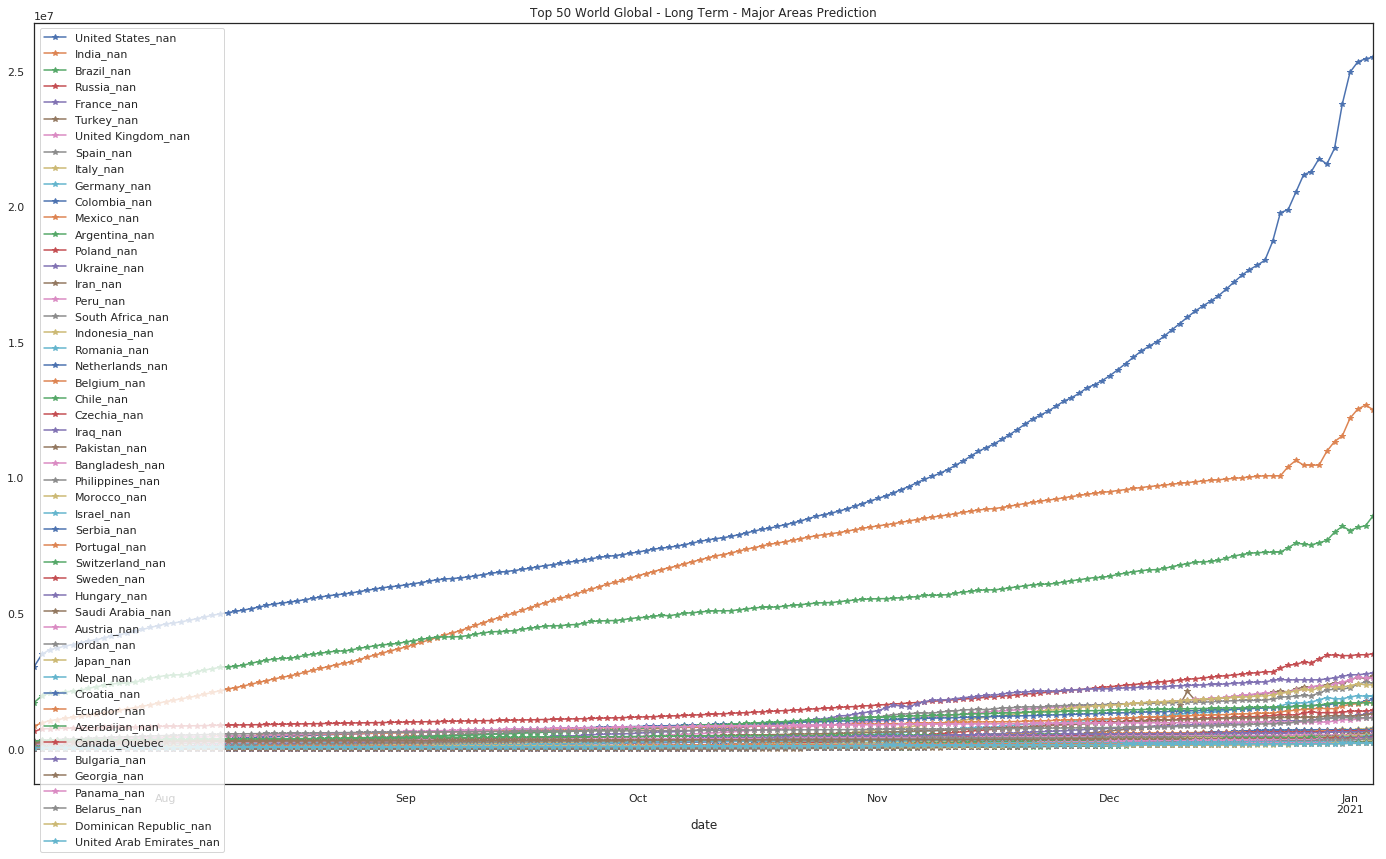

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

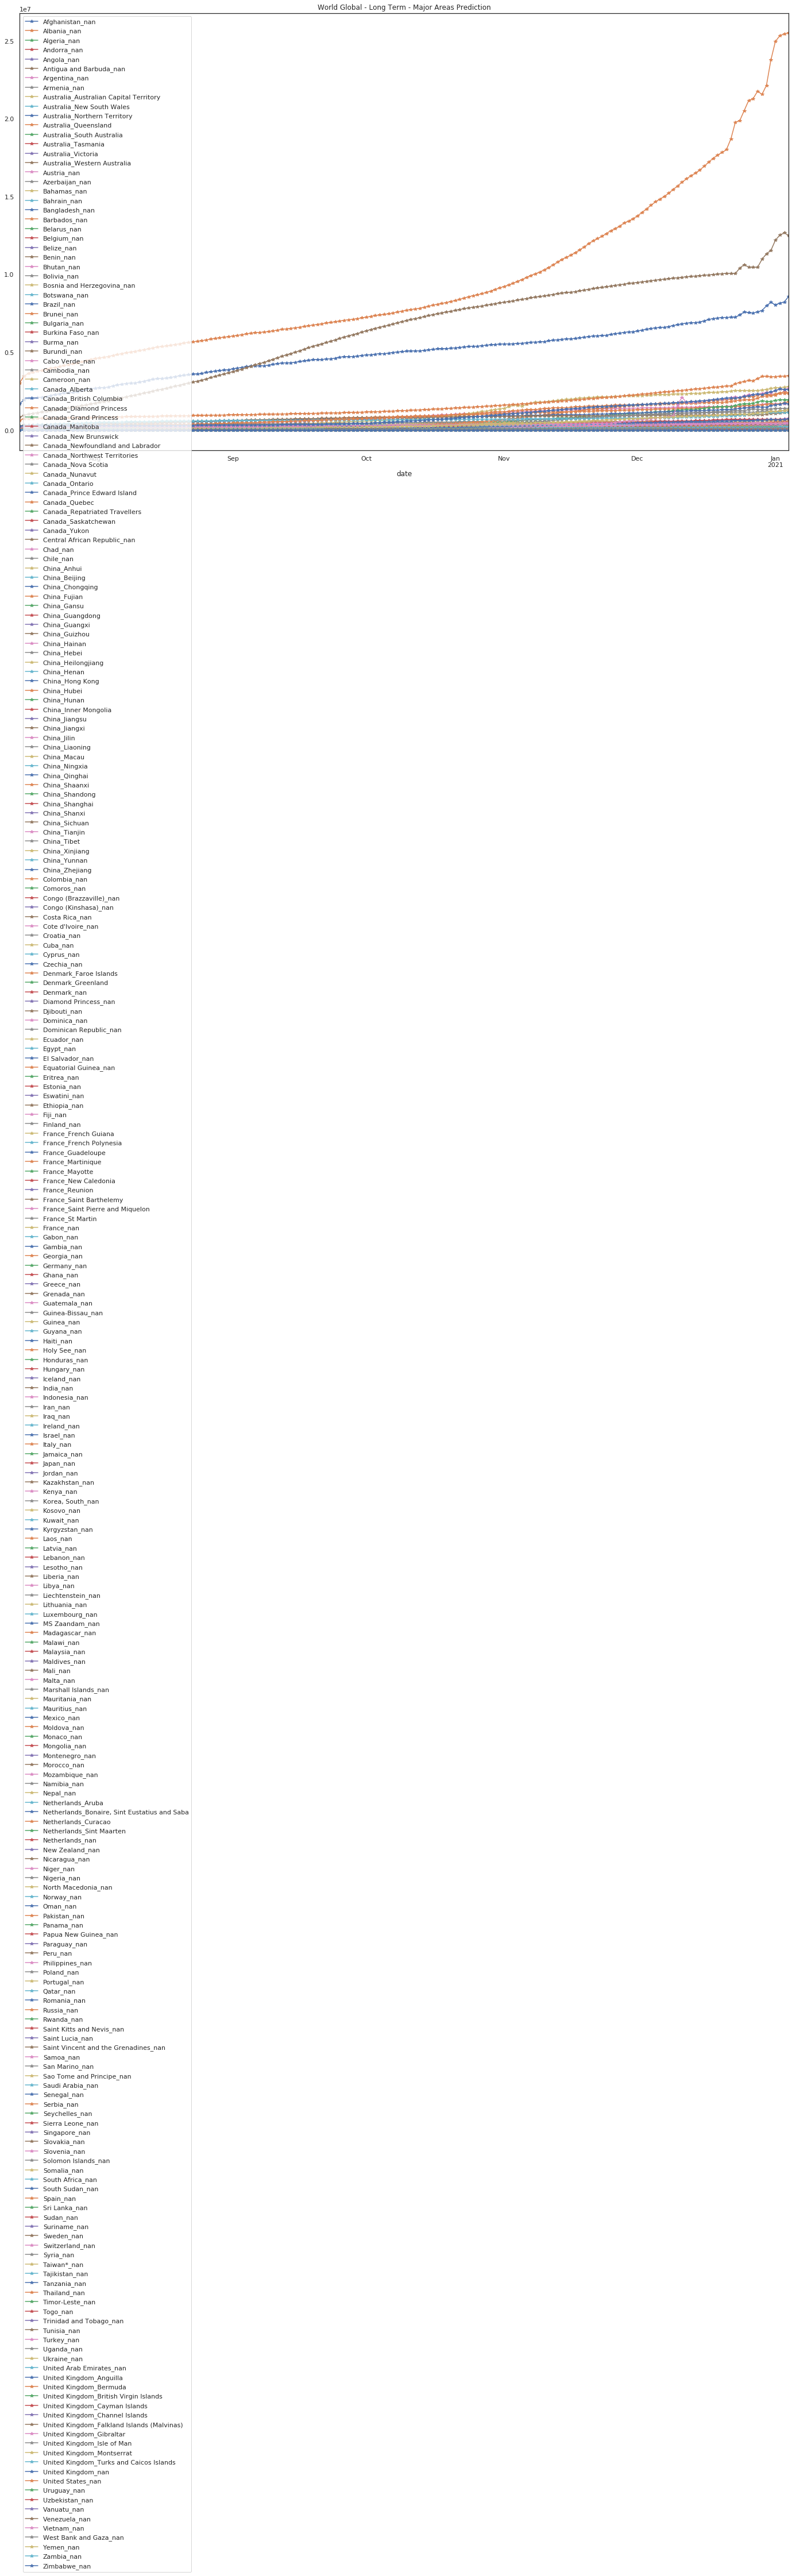

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38236.0       9304.0      43830.0       1124.0   
2020-08-30          38255.0       9412.0      44196.0       1196.0   
2020-08-31          38267.0       9523.0      44543.0       1241.0   
2020-09-01          38297.0       9605.0      44880.0       1176.0   
2020-09-02          38352.0       9754.0      45205.0       1232.0   
2020-09-03          38402.0       9858.0      45516.0       1199.0   
2020-09-04          38422.0       9983.0      45822.0       1281.0   
2020-09-05          38434.0      10117.0      46122.0       1215.0   
2020-09-06          38498.0      10261.0      46419.0       1274.0   
2020-09-07          38601.0      10406.0      46711.0       1314.0   
2020-09-08          38640.0      10559.0      46999.0       1261.0   
2020-09-09          38652.0      10712.0      47280.0       1368.0   
2020-09-10          38677.0      10864.0      47554.0       1301.0   
2020-09-11          38707.0      11022.0      47819.0       1408.0   
2020-09-12          38742.0      11184.0      48075.0       1344.0   
2020-09-13          38812.0      11352.0      48322.0       1417.0   
2020-09-14          38882.0      11519.0      48564.0       1499.0   
2020-09-15          38927.0      11675.0      48804.0       1438.0   
2020-09-16          38965.0      11826.0      49038.0       1583.0   
2020-09-17          38980.0      11961.0      49267.0       1483.0   
2020-09-18          38997.0      12089.0      49489.0       1624.0   
2020-09-19          39021.0      12240.0      49699.0       1564.0   
2020-09-20          39131.0      12389.0      49903.0       1654.0   
2020-09-21          39199.0      12542.0      50100.0       1756.0   
2020-09-22          39205.0      12684.0      50292.0       1681.0   
2020-09-23          39251.0      12812.0      50480.0       1844.0   
2020-09-24          39278.0      12945.0      50660.0       1753.0   
2020-09-25          39289.0      13064.0      50836.0       1896.0   
2020-09-26          39295.0      13177.0      50999.0       1836.0   
2020-09-27          39322.0      13290.0      51151.0       1903.0   
...                     ...          ...          ...          ...   
2020-12-06          47387.0      42923.0      88243.0       7005.0   
2020-12-07          47611.0      43642.0      88846.0       7050.0   
2020-12-08          47819.0      44338.0      89388.0       7084.0   
2020-12-09          47961.0      45102.0      90006.0       7127.0   
2020-12-10          48135.0      45949.0      90593.0       7162.0   
2020-12-11          48227.0      46797.0      91147.0       7190.0   
2020-12-12          48284.0      47653.0      91676.0       7236.0   
2020-12-13          48577.0      48480.0      92152.0       7288.0   
2020-12-14          48831.0      49134.0      92639.0       7338.0   
2020-12-15          49044.0      49883.0      93125.0       7382.0   
2020-12-16          49274.0      50571.0      93567.0       7382.0   
2020-12-17          49472.0      51291.0      93996.0       7446.0   
2020-12-18          49714.0      51953.0      94433.0       7466.0   
2020-12-19          49793.0      52442.0      94857.0       7519.0   
2020-12-20          49865.0      52918.0      95274.0       7560.0   
2020-12-21          50078.0      53324.0      95732.0       7577.0   
2020-12-22          50116.0      56225.0      96275.0       7602.0   
2020-12-23          50078.0      57457.0      96379.0       7825.0   
2020-12-24          50083.0      56711.0      98425.0       8010.0   
2020-12-25          50622.0      56711.0      99672.0       8254.0   
2020-12-26          51447.0      59996.0      98771.0       8254.0   
2020-12-27          51548.0      63713.0     100599.0       8254.0   
2020-12-28          51981.0      63541.0     101479.0       8697.0   
2020-12-29          53239.0      63117.0     103824.0       8697.0   
2020-12-30

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
247                                Thailand_nan  15.870032  100.992541   
248                             Timor-Leste_nan  -8.874217  125.727539   
249                                    Togo_nan   8.619500    0.824800   
250                     Trinidad and Tobago_nan  10.691800  -61.222500   
251                                 Tunisia_nan  33.886917    9.537499   
252                                  Turkey_nan  38.963700   35.243300   
253                           United States_nan  40.000000 -100.000000   
254                                  Uganda_nan   1.373333   32.290275   
255                                 Ukraine_nan  48.379400   31.165600   
256                    United Arab Emirates_nan  23.424076   53.847818   
257                     United Kingdom_Anguilla  18.220600  -63.068600   
258                      United Kingdom_Bermuda  32.307800  -64.750500   
259       United Kingdom_British Virgin Islands  18.420700  -64.640000   
260               United Kingdom_Cayman Islands  19.313300  -81.254600   
261              United Kingdom_Channel Islands  49.372300   -2.364400   
262  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
263                    United Kingdom_Gibraltar  36.140800   -5.353600   
264                  United Kingdom_Isle of Man  54.236100   -4.548100   
265                   United Kingdom_Montserrat  16.742498  -62.187366   
266     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
267                          United Kingdom_nan  55.378100   -3.436000   
268                                 Uruguay_nan -32.522800  -55.765800   
269                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      17            Azerbaijan_nan  40.143100   47.576900   
3      20            Bangladesh_nan  23.685000   90.356300   
4      22               Belarus_nan  53.709800   27.953400   
5      23               Belgium_nan  50.833300    4.469936   
6      30                Brazil_nan -14.235000  -51.925300   
7      32              Bulgaria_nan  42.733900   25.485800   
8      53             Canada_Quebec  52.939900  -73.549100   
9      59                 Chile_nan -35.675100  -71.543000   
10     93              Colombia_nan   4.570900  -74.297300   
11     99               Croatia_nan  45.100000   15.200000   
12    102               Czechia_nan  49.817500   15.473000   
13    109    Dominican Republic_nan  18.735700  -70.162700   
14    110               Ecuador_nan  -1.831200  -78.183400   
15    130                France_nan  46.227600    2.213700   
16    133               Georgia_nan  42.315400   43.356900   
17    134               Georgia_nan  42.315400   43.356900   
18    135               Germany_nan  51.165691   10.451526   
19    147               Hungary_nan  47.162500   19.503300   
20    149                 India_nan  20.593684   78.962880   
21    150             Indonesia_nan  -0.789300  113.921300   
22    151                  Iran_nan  32.427908   53.688046   
23    152                  Iraq_nan  33.223191   43.679291   
24    154                Israel_nan  31.046051   34.851612   
25    155                Israel_nan  31.046051   34.851612   
26    156                 Italy_nan  41.871940   12.567380   
27    158                 Japan_nan  36.204824  138.252924   
28    159                Jordan_nan  31.240000   36.510000   
29    186                Mexico_nan  23.634500 -102.552800   
30    191               Morocco_nan  31.791700   -7.092600   
31    194                 Nepal_nan  28.166700   84.250000   
32    199           Netherlands_nan  52.132600    5.291300   
33    207              Pakistan_nan  30.375300   69.345100   
34    208                Panama_nan   8.538000  -80.782100   
35    211                  Peru_nan  -9.190000  -75.015200   
36    212           Philippines_nan  12.879721  121.774017   
37    213                Poland_nan  51.919400   19.145100   
38    214              Portugal_nan  39.399900   -8.224500   
39    216               Romania_nan  45.943200   24.966800   
40    217                Russia_nan  61.524010  105.318756   
41    225          Saudi Arabia_nan  23.885942   45.079162   
42    227                Serbia_nan  44.016500   21.005900   
43    235          South Africa_nan -30.559500   22.937500   
44    237                 Spain_nan  40.463667   -3.749220   
45    241                Sweden_nan  60.128161   18.643501   
46    242           Switzerland_nan  46.818200    8.227500   
47    252                Turkey_nan  38.963700   35.243300   
48    253         United States_nan  40.000000 -100.000000   
49    255               Ukraine_nan  48.379400   31.165600   
50    256  United Arab Emirates_nan  23.424076   53.847818   
51    267        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              105996.0             111146.0             119101.0   
1               26190.0              26290.0              19270.0   
2               31844.0              32272.0              26165.0   
3              177518.0             193590.0             199167.0   
4               66347.0              66503.0              65623.0   
5               64116.0              64434.0              63238.0   
6             1715788.0            1966748.0            2062640.0   
7               16407.0              16638.0               8144.0   
8               58900.0              59023.0              57001.0   
9              288228.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()